# -*- coding: utf-8 -*-
__author__ = 'Jiahui Zhang'

In [1]:
import os
os.chdir("/Users/zhangjiahui/Desktop/Haohan Research/PM_play")
# 方法 1: 打印当前工作目录
print(os.getcwd())
from model.personalizedModel import PersonalizedThroughMixedModel

import numpy as np
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt

/Users/zhangjiahui/Desktop/Haohan Research/PM_play


/Users/zhangjiahui/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


R shape = (815,), mean=0.0000, std=1.0000


100%|██████████| 815/815 [20:46<00:00,  1.53s/it]


[SAVE] pvalues.npy -> /Users/zhangjiahui/Desktop/Haohan Research/Alz GWAS data/Prepared_data4/pvalues.npy  | P shape = (815, 3248)
[INFO] Used features -> X: 3248 (from 3248), C: 71278 (from 71278)


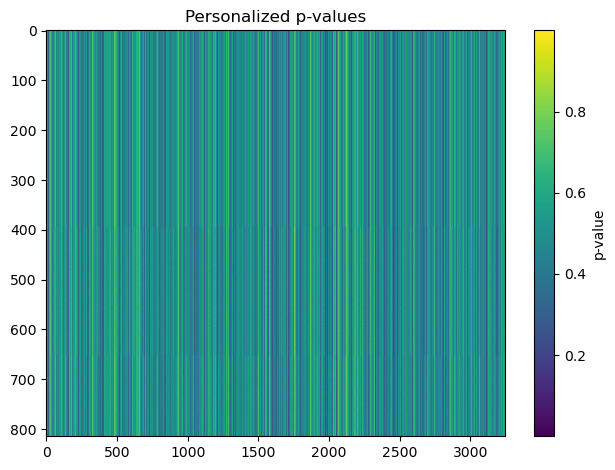

In [2]:
from pathlib import Path
def run_exp():
    # ---- 路径 ----
    BASE = Path("/Users/zhangjiahui/Desktop/Haohan Research/Alz GWAS data/Prepared_data4")

    # ---- 读入对齐后的数据 ----
    Y = np.load(BASE / "Y.npy")          # (n,)
    X = np.load(BASE / "X.npy")          # (n, p_exon)
    C = np.load(BASE / "C.npy")          # (n, p_nonexon)
    covariate = np.load(BASE / "covariates.npy") # (n, k)

   
    # ---- 回归协变量，得到残差 R 并标准化 ----
    lr = LinearRegression()
    lr.fit(covariate, Y.astype(float))
    R = Y.astype(float) - lr.predict(covariate)
    R = (R - R.mean()) / (R.std() + 1e-8)
    print(f"R shape = {R.shape}, mean={np.mean(R):.4f}, std={np.std(R):.4f}")

    # ---- 拟合 Personalized Mixed Model ----
    pl = PersonalizedThroughMixedModel()
    B, P = pl.fit(X, R, C)

    # ---- 存储 & 可视化 ----
    np.save(BASE / "pvalues.npy", P)
    print(f"[SAVE] pvalues.npy -> {BASE/'pvalues.npy'}  | P shape = {np.shape(P)}")
    print(f"[INFO] Used features -> X: {X.shape[1]} (from {X.shape[1]}), "
          f"C: {C.shape[1]} (from {C.shape[1]})")

    plt.imshow(P, aspect='auto')
    plt.colorbar(label='p-value')
    plt.title('Personalized p-values')
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    run_exp()

fig 1 2

In [20]:
import numpy as np
import pandas as pd
from pathlib import Path

def results_study_like_paper():
    BASE = Path("/Users/zhangjiahui/Desktop/Haohan Research/Alz GWAS data/Prepared_data4")

    # ---- 读入数据 ----
    P = np.load(BASE / "pvalues.npy")                  # (n, p_exon_after_clean)
    Y = np.load(BASE / "Y.npy")                # (n,)
    sids = pd.read_csv(BASE / "ids.txt", header=None)[0].astype(str).tolist()

    # ✅ ---- 改动部分：直接读取 exonMarkers_after_clean.txt ----
    marker_file = BASE / "exonMarkers_after_clean.txt"
    if not marker_file.exists():
        raise FileNotFoundError(f"未找到 {marker_file}。请先运行 run_exp_adni.py 生成。")

    markers = [line.strip() for line in open(marker_file, "r")]
    if len(markers) != P.shape[1]:
        raise ValueError(f"标记列数 {len(markers)} 与 P.shape[1]={P.shape[1]} 不一致。")

    # ---- 形状检查 ----
    n, p = P.shape
    assert len(Y) == n and len(sids) == n, f"行数不一致：P={P.shape}, Y={Y.shape}, ids={len(sids)}"
    assert len(markers) == p, f"列数不一致：markers={len(markers)}, P.shape[1]={p}"

    alpha = 0.05
    sel = (P < alpha).astype(int)          # (n, p) 0/1
    per_person_counts = sel.sum(axis=1)    # 每人被选中的 SNP 数
    per_snp_counts    = sel.sum(axis=0)    # 每个 SNP 被多少人选中

    # ===== Table 2：对“被选中 SNP > 10”的个体，列出该个体 Top-10 =====
    t2_path = BASE / "Table2_individual_top10.csv"
    with open(t2_path, "w") as f:
        f.write("sid,label,num_selected,top10_markers,top10_pvals\n")
        for i, cnt in enumerate(per_person_counts):
            if cnt > 10:
                order = np.argsort(P[i])                  # 该个体按 p 从小到大
                top = [j for j in order if P[i, j] < alpha][:10]
                top_markers = ";".join(markers[j] for j in top)
                top_pvals   = ";".join(f"{P[i,j]:.2e}" for j in top)
                f.write(f"{sids[i]},{int(Y[i])},{int(cnt)},{top_markers},{top_pvals}\n")

    # ===== Table 1：跨人群计次 Top-10（并列用最小 p 打破） =====
    min_p = P.min(axis=0)
    order = np.lexsort((min_p, -per_snp_counts))
    top10 = order[:10]

    t1_path = BASE / "Table1_population_top_snps.csv"
    with open(t1_path, "w") as f:
        f.write("marker,selected_count,min_p\n")
        for j in top10:
            f.write(f"{markers[j]},{int(per_snp_counts[j])},{min_p[j]:.3e}\n")

    print(f"[DONE] 写出：\n - {t2_path}\n - {t1_path}")

# 直接调用
if __name__ == "__main__":
    results_study_like_paper()

[DONE] 写出：
 - /Users/zhangjiahui/Desktop/Haohan Research/Alz GWAS data/Prepared_data4/Table2_individual_top10.csv
 - /Users/zhangjiahui/Desktop/Haohan Research/Alz GWAS data/Prepared_data4/Table1_population_top_snps.csv


paper 3 method

In [36]:
# make_fig3_clusters.py  (AD-only; Prepared_data2; robust IO)
from pathlib import Path
import numpy as np, pandas as pd, json
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import silhouette_score

# -------- Paths (match your current repo) --------
BASE = Path("/Users/zhangjiahui/Desktop/Haohan Research/Alz GWAS data/Prepared_data4")

# p-values (prefer AD_PC20; fallback to generic)
PV_CANDIDATES = [
    BASE / "pvalues.npy"
]
for pth in PV_CANDIDATES:
    if pth.exists():
        PV_PATH = pth
        break
else:
    raise FileNotFoundError("p-values file not found in Prepared_data4.")

# IDs (txt or npy) + Y (aligned-for-C)
ID_TXT = BASE / "ids.txt"
ID_NPY = BASE / "ids.npy"
if ID_TXT.exists():
    IDS = np.loadtxt(ID_TXT, dtype=str)
elif ID_NPY.exists():
    IDS = np.load(ID_NPY).astype(str)
else:
    # fallback to generic ids.txt
    IDS = np.loadtxt(BASE / "ids.txt", dtype=str)

Y_PATH = BASE / "Y.npy"
if not Y_PATH.exists():
    # fallback to generic Y.npy
    Y_PATH = BASE / "Y.npy"

# -------- Load --------
P = np.load(PV_PATH)                      # shape (n, p)
Y = np.load(Y_PATH).reshape(-1)
assert P.shape[0] == len(IDS) == Y.shape[0], "[ALIGN] P/IDS/Y not aligned."

# AD-only mask (你的编码里 AD=1, CN=0)
mask_ad = (Y == 1)
P_ad = P[mask_ad]
IDS_ad = IDS[mask_ad]
n_ad = P_ad.shape[0]
assert n_ad >= 4, "Too few AD subjects for clustering."

# -------- Transform: -log10 & guard constant-rows --------
P_ad = np.clip(P_ad.astype(float), 1e-12, 1.0)
Q = -np.log10(P_ad)                       # samples x features

# 若某些样本行方差为0，轻微抖动避免距离为NaN
rs = np.std(Q, axis=1)
if (rs == 0).any():
    rng = np.random.default_rng(0)
    Q[rs == 0] += 1e-9 * rng.standard_normal(Q[rs == 0].shape)

# -------- Pairwise distance (correlation) & linkage --------
# 样本间的相关距离 → condense → linkage
Dcond = pdist(Q, metric="correlation")
Z = linkage(Dcond, method="average")
D = squareform(Dcond)                     # for silhouette

# -------- Choose k (paper uses k=2; keep an option to search 2..min(6,n_ad-1)) --------
FORCE_K2 = True
if FORCE_K2:
    best_k, best_s = 2, np.nan
else:
    best_k, best_s, rec = None, -1.0, []
    for k in range(2, min(6, n_ad)):      # small search window
        lab = fcluster(Z, k, criterion="maxclust")
        # silhouette with precomputed distances
        s = silhouette_score(D, lab, metric="precomputed")
        rec.append((k, float(s)))
        if s > best_s:
            best_k, best_s = k, s

# -------- Final clustering --------
labels = fcluster(Z, best_k, criterion="maxclust")  # 1..k integers

# -------- Save figures --------
plt.figure(figsize=(10, 4))
dendrogram(Z, no_labels=True, count_sort=True)
plt.title("Dendrogram (AD-only)")
plt.tight_layout()
plt.savefig(BASE / "Fig3_AD_only_dendrogram.png", dpi=150)
plt.close()

if not FORCE_K2:
    ks, ss = zip(*rec) if len(rec) else ([], [])
    if ks:
        plt.figure(figsize=(5, 4))
        plt.plot(ks, ss, marker="o")
        plt.title("Silhouette vs k (AD-only)")
        plt.xlabel("k"); plt.ylabel("silhouette")
        plt.tight_layout()
        plt.savefig(BASE / "Fig3_AD_only_silhouette_by_k.png", dpi=150)
        plt.close()

# heatmap sorted by cluster
order = np.argsort(labels)
Qs = Q[order]
plt.figure(figsize=(8, 5))
plt.imshow(Qs, aspect="auto")
plt.colorbar(label="-log10(p)")
plt.title(f"AD-only heatmap sorted by cluster (k={best_k})")
plt.tight_layout()
plt.savefig(BASE / "Fig3_AD_only_heatmap_sorted_by_cluster.png", dpi=150)
plt.close()

# -------- Save groups for Fig4 --------
groups_df = pd.DataFrame({
    "id": IDS_ad.astype(str),
    "cluster": labels.astype(int)
})
# 论文里是两组（蓝/橙）；这里直接输出1/2。命名与后续脚本一致：
groups_df.to_csv(BASE / "figure3_groups.csv", index=False)

# 也保存一个仅限AD的版本，避免混淆
groups_df.to_csv(BASE / f"AD_only_clusters_k{best_k}.csv", index=False)

# -------- Summary --------
summary = {
    "pvalues_file": PV_PATH.name,
    "n_AD_individuals": int(n_ad),
    "n_features": int(P_ad.shape[1]),
    "best_k": int(best_k),
    "best_silhouette": (None if np.isnan(best_s) else round(float(best_s), 6)),
    "distance": "correlation",
    "linkage": "average",
    "ids_source": ("ids" if (ID_TXT.exists() or ID_NPY.exists()) else "ids.txt")
}
with open(BASE / "Fig3_AD_only_summary.json", "w") as f:
    json.dump(summary, f, indent=2)

print("[Fig3] done:",
      f"\n  AD n={n_ad}, features={P_ad.shape[1]}",
      f"\n  best_k={best_k}, silhouette={summary['best_silhouette']}")


[Fig3] done: 
  AD n=251, features=3248 
  best_k=2, silhouette=None


In [ ]:
# make_fig3_clusters_with_styled_singlecolor_dendro.py
from pathlib import Path
import numpy as np, pandas as pd, json
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import silhouette_score


def export_single_cluster_dendrogram_lines_styled(
    Z,
    labels,
    target_cluster: int,
    outpath,
    *,
    count_sort=True,
    figsize=(10, 4),
    line_color="#F28E2B",      # orange default
    linewidth=1.0,             # thinner lines
    dpi=300,
    facecolor="white",         # match your figure style
    transparent=False,         # IMPORTANT: avoid black background in viewers
    tight_crop=True,           # auto-crop to the target cluster lines
    crop_pad_frac=0.02,        # small padding for aesthetics
):
    """
    Export a dendrogram image that contains ONLY the line segments whose subtree is purely within `target_cluster`.
    Style: white background, no axes, thin lines, tight crop.

    NOTE: scipy dendrogram link_color_func MUST return a matplotlib *color string*.
    """

    labels = np.asarray(labels).astype(int)
    n = len(labels)

    # --- Determine "pure cluster membership" for each internal node (0= mixed) ---
    node_cluster_cache = {}

    def node_cluster(node_id: int) -> int:
        if node_id < n:
            return int(labels[node_id])
        if node_id in node_cluster_cache:
            return node_cluster_cache[node_id]
        left = int(Z[node_id - n, 0])
        right = int(Z[node_id - n, 1])
        cl = node_cluster(left)
        cr = node_cluster(right)
        node_cluster_cache[node_id] = cl if cl == cr else 0
        return node_cluster_cache[node_id]

    # Must return color strings only
    def link_color_func(node_id: int) -> str:
        return line_color if node_cluster(node_id) == target_cluster else "k"

    # get dendrogram geometry without plotting
    d = dendrogram(
        Z,
        no_labels=True,
        count_sort=count_sort,
        no_plot=True,
        link_color_func=link_color_func,
    )

    # create figure with white background
    fig, ax = plt.subplots(figsize=figsize, facecolor=facecolor)
    ax.set_facecolor(facecolor)

    # plot only the target-colored segments; also collect bounds for tight crop
    xs_all, ys_all = [], []
    for xs, ys, c in zip(d["icoord"], d["dcoord"], d["color_list"]):
        if c == line_color:
            ax.plot(xs, ys, color=line_color, linewidth=linewidth, solid_capstyle="round")
            xs_all.extend(xs)
            ys_all.extend(ys)

    ax.set_axis_off()

    # tight crop to the drawn segments (removes huge blank areas)
    if tight_crop and len(xs_all) > 0:
        xmin, xmax = min(xs_all), max(xs_all)
        ymin, ymax = min(ys_all), max(ys_all)
        # add small padding
        xpad = (xmax - xmin) * crop_pad_frac if xmax > xmin else 1.0
        ypad = (ymax - ymin) * crop_pad_frac if ymax > ymin else 0.01
        ax.set_xlim(xmin - xpad, xmax + xpad)
        ax.set_ylim(max(0, ymin - ypad), ymax + ypad)
    else:
        # fallback (should rarely trigger)
        ax.set_xlim(0, 10 * n)
        if len(d["dcoord"]) > 0:
            ax.set_ylim(0, max(max(y) for y in d["dcoord"]) * 1.02)

    plt.tight_layout(pad=0)
    plt.savefig(
        outpath,
        dpi=dpi,
        facecolor=facecolor,
        transparent=transparent,
        bbox_inches="tight",
        pad_inches=0,
    )
    plt.close(fig)


# =========================
# Your original pipeline
# =========================
BASE = Path("/Users/zhangjiahui/Desktop/Haohan Research/Alz GWAS data/Prepared_data4")

PV_PATH = BASE / "pvalues.npy"
if not PV_PATH.exists():
    raise FileNotFoundError("pvalues.npy not found in Prepared_data4.")

ID_TXT = BASE / "ids.txt"
ID_NPY = BASE / "ids.npy"
if ID_TXT.exists():
    IDS = np.loadtxt(ID_TXT, dtype=str)
elif ID_NPY.exists():
    IDS = np.load(ID_NPY).astype(str)
else:
    raise FileNotFoundError("ids.txt or ids.npy not found.")

Y_PATH = BASE / "Y.npy"
if not Y_PATH.exists():
    raise FileNotFoundError("Y.npy not found in Prepared_data4.")

P = np.load(PV_PATH)
Y = np.load(Y_PATH).reshape(-1)
assert P.shape[0] == len(IDS) == Y.shape[0], "[ALIGN] P/IDS/Y not aligned."

mask_ad = (Y == 1)
P_ad = P[mask_ad]
IDS_ad = IDS[mask_ad]
n_ad = P_ad.shape[0]
assert n_ad >= 4, "Too few AD subjects for clustering."

P_ad = np.clip(P_ad.astype(float), 1e-12, 1.0)
Q = -np.log10(P_ad)

rs = np.std(Q, axis=1)
if (rs == 0).any():
    rng = np.random.default_rng(0)
    Q[rs == 0] += 1e-9 * rng.standard_normal(Q[rs == 0].shape)

Dcond = pdist(Q, metric="correlation")
Z = linkage(Dcond, method="average")

FORCE_K2 = True
best_k = 2 if FORCE_K2 else 2
labels = fcluster(Z, best_k, criterion="maxclust")

# =========================
# NEW styled outputs
# =========================
# 1) Orange-only (cluster 1)
export_single_cluster_dendrogram_lines_styled(
    Z, labels, target_cluster=1,
    outpath=BASE / "Fig3_AD_only_dendrogram_cluster1_orange_styled.png",
    figsize=(10, 4),
    line_color="#F28E2B",   # orange
    linewidth=1.0,          # thin
    dpi=300,
    facecolor="white",
    transparent=False,
    tight_crop=True,
)

# 2) Blue-only (cluster 2)
export_single_cluster_dendrogram_lines_styled(
    Z, labels, target_cluster=2,
    outpath=BASE / "Fig3_AD_only_dendrogram_cluster2_blue_styled.png",
    figsize=(10, 4),
    line_color="#4E79A7",   # blue
    linewidth=1.0,          # thin
    dpi=300,
    facecolor="white",
    transparent=False,
    tight_crop=True,
)

print("Saved styled dendrograms:",
      BASE / "Fig3_AD_only_dendrogram_cluster1_orange_styled.png",
      BASE / "Fig3_AD_only_dendrogram_cluster2_blue_styled.png")


[DONE]
 Orange compact block: /Users/zhangjiahui/Desktop/Haohan Research/Alz GWAS data/Prepared_data4/Fig3_orange_block_compact.png
 Blue only styled     : /Users/zhangjiahui/Desktop/Haohan Research/Alz GWAS data/Prepared_data4/Fig3_blue_only_styled.png
 cap_used (raw height): 0.0002043129544942346


In [52]:
# make_fig3_clusters_with_styled_singlecolor_dendro_crop_right.py
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

def export_single_cluster_dendrogram_lines_styled(
    Z,
    labels,
    target_cluster: int,
    outpath,
    *,
    count_sort=True,
    figsize=(10, 4),
    line_color="#C88453", # 更新为 Keynote 截图中的精确橙色
    linewidth=1.0,
    dpi=300,
    facecolor="white",
    transparent=False,
    tight_crop=True,
    crop_pad_frac=0.02,
    crop_right_by_y=False,
    y_eps=1e-12,
):
    """
    导出仅包含特定聚类分支的树状图线条。
    """
    labels = np.asarray(labels).astype(int)
    n = len(labels)

    node_cluster_cache = {}

    def node_cluster(node_id: int) -> int:
        if node_id < n:
            return int(labels[node_id])
        if node_id in node_cluster_cache:
            return node_cluster_cache[node_id]
        left = int(Z[node_id - n, 0])
        right = int(Z[node_id - n, 1])
        cl = node_cluster(left)
        cr = node_cluster(right)
        node_cluster_cache[node_id] = cl if cl == cr else 0
        return node_cluster_cache[node_id]

    def link_color_func(node_id: int) -> str:
        return line_color if node_cluster(node_id) == target_cluster else "k"

    d = dendrogram(
        Z,
        no_labels=True,
        count_sort=count_sort,
        no_plot=True,
        link_color_func=link_color_func,
    )

    fig, ax = plt.subplots(figsize=figsize, facecolor=facecolor)
    ax.set_facecolor(facecolor)

    xs_all, ys_all = [], []
    xs_posy = []

    for xs, ys, c in zip(d["icoord"], d["dcoord"], d["color_list"]):
        if c != line_color:
            continue

        ax.plot(xs, ys, color=line_color, linewidth=linewidth, solid_capstyle="round")

        xs_all.extend(xs)
        ys_all.extend(ys)

        for x, y in zip(xs, ys):
            if y > y_eps:
                xs_posy.append(x)

    ax.set_axis_off()

    if tight_crop and len(xs_all) > 0:
        xmin = min(xs_all)
        xmax_all = max(xs_all)

        if crop_right_by_y and len(xs_posy) > 0:
            xmax = max(xs_posy)
        else:
            xmax = xmax_all

        ymin = min(ys_all)
        ymax = max(ys_all)

        xpad = (xmax - xmin) * crop_pad_frac if xmax > xmin else 1.0
        ypad = (ymax - ymin) * crop_pad_frac if ymax > ymin else 0.01

        ax.set_xlim(xmin - xpad, xmax + xpad)
        ax.set_ylim(max(0, ymin - ypad), ymax + ypad)

    plt.tight_layout(pad=0)
    plt.savefig(
        outpath,
        dpi=dpi,
        facecolor=facecolor,
        transparent=transparent,
        bbox_inches="tight",
        pad_inches=0,
    )
    plt.close(fig)

# =========================
# 数据加载与路径处理
# =========================
BASE = Path("/Users/zhangjiahui/Desktop/Haohan Research/Alz GWAS data/Prepared_data4")

PV_PATH = BASE / "pvalues.npy"
Y_PATH = BASE / "Y.npy"
ID_PATH = BASE / "ids.txt"

# 加载 AD 数据
P = np.load(PV_PATH)
Y = np.load(Y_PATH).reshape(-1)
mask_ad = (Y == 1)
P_ad = P[mask_ad]

# 转换与聚类
Q = -np.log10(np.clip(P_ad.astype(float), 1e-12, 1.0))
Z = linkage(pdist(Q, metric="correlation"), method="average")
labels = fcluster(Z, 2, criterion="maxclust")

# =========================
# 导出图表
# =========================

# 导出 Cluster 1 (橙色)
export_single_cluster_dendrogram_lines_styled(
    Z, labels, target_cluster=1,
    outpath=BASE / "Fig3_AD_only_dendrogram_cluster1_orange_final.png",
    line_color="#C88453",  # 已修正为截图中的精确颜色
    linewidth=2,
    crop_right_by_y=True
)

# 导出 Cluster 2 (蓝色)
export_single_cluster_dendrogram_lines_styled(
    Z, labels, target_cluster=2,
    outpath=BASE / "Fig3_AD_only_dendrogram_cluster2_blue_final.png",
    line_color="#4E79A7", # 可选：如需同步修改蓝色，请告知数值
    linewidth=2,
    crop_right_by_y=False
)

print(f"完成！图片已保存至: {BASE}")

完成！图片已保存至: /Users/zhangjiahui/Desktop/Haohan Research/Alz GWAS data/Prepared_data4


fig 4 paper method

In [22]:
# make_fig4_boxplots_v2.py  (paper-aligned; uses Prepared_data2 + figure3_groups.csv)
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from scipy.stats import mannwhitneyu, ttest_ind

# -------- Paths --------
BASE = Path("/Users/zhangjiahui/Desktop/Haohan Research/Alz GWAS data")
PREP = BASE / "Prepared_data4"                      # <- 新：对齐你的当前目录
OUT  = PREP / "fig4_outputs"
OUT.mkdir(parents=True, exist_ok=True)

ADAS_CSV   = BASE / "ADNI_ADAS.csv"
CDR_CSV    = BASE / "ADNI_CDR.csv"
MMSE_CSV   = BASE / "ADNI_MMSE.csv"
NEURO_CSV  = BASE / "ADNI_NEUROBAT.csv"
ITEM_CSV   = BASE / "ITEM.csv"                      # ADAS item-level（可选）

# === 分组：优先使用 Prepared_data2/figure3_groups.csv；否则回退 AD_only_clusters_k*.csv ===
def load_groups(prep_dir: Path) -> pd.DataFrame:
    primary = prep_dir / "figure3_groups.csv"
    if primary.exists():
        df = pd.read_csv(primary)
    else:
        cand = sorted(prep_dir.glob("AD_only_clusters_k*.csv"))
        if not cand:
            raise FileNotFoundError("未找到分组：既没有 figure3_groups.csv 也没有 AD_only_clusters_k*.csv")
        df = pd.read_csv(cand[-1])

    # 统一ID列名（Fig3我给你的脚本导出列名是 'id'）
    id_col = "id" if "id" in df.columns else ("sid" if "sid" in df.columns else None)
    if id_col is None and "PTID" in df.columns: id_col = "PTID"
    if id_col is None: raise ValueError("分组文件缺少 id/sid/PTID 列。")
    # 统一cluster列
    cl_col = "cluster" if "cluster" in df.columns else ("group" if "group" in df.columns else None)
    if cl_col is None: raise ValueError("分组文件缺少 cluster/group 列。")

    grp = df[[id_col, cl_col]].copy()
    grp.columns = ["sid", "cluster"]

    # 把 cluster 稳定映射到 {1,2}
    uniq = sorted(pd.unique(grp["cluster"].astype(int)))
    if len(uniq) < 2:
        raise ValueError("只有一个簇，无法做两组比较。")
    map12 = {uniq[0]: 1, uniq[1]: 2}        # 论文用两组
    grp["group"] = grp["cluster"].astype(int).map(map12)
    return grp[["sid", "group"]]

# -------- Helpers --------
_pat = re.compile(r"(\d{3}_S_\d{4})")
def norm_ptid(x: str) -> str:
    m = _pat.search(str(x))
    return m.group(1) if m else str(x)

def read_csv_with_ptid(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    if "PTID" not in df.columns:
        if "RID" in df.columns:
            df["PTID"] = df["RID"].astype(str)
        else:
            raise ValueError(f"{path} 缺少 PTID/RID 列。")
    df["PTID"] = df["PTID"].astype(str)
    return df

def pick_baseline(df: pd.DataFrame | None, prefer="bl") -> pd.DataFrame:
    if df is None: return pd.DataFrame(columns=["PTID"])
    df = df.copy()
    if "VISCODE" in df.columns:
        vis = df["VISCODE"].astype(str).str.lower()
        if (vis == prefer).any():
            out = df[vis == prefer].copy()
        elif (vis == "sc").any():
            out = df[vis == "sc"].copy()
        else:
            out = df
    else:
        out = df
    if "EXAMDATE" in out.columns:
        out = out.sort_values("EXAMDATE")
    return out.drop_duplicates(subset=["PTID"], keep="first").copy()

def pvals_2groups(a, b):
    a = np.asarray(a, float); b = np.asarray(b, float)
    a = a[~np.isnan(a)]; b = b[~np.isnan(b)]
    if len(a) < 2 or len(b) < 2: return np.nan, np.nan
    u_p = mannwhitneyu(a, b, alternative="two-sided").pvalue
    t_p = ttest_ind(a, b, equal_var=False, nan_policy="omit").pvalue  # Welch
    return u_p, t_p

# -------- Q4 detector --------
def find_q4_column(df: pd.DataFrame, source_name: str) -> str | None:
    cols = list(df.columns)
    lower_map = {c.lower(): c for c in cols}
    candidates = ["q4","q4score","q4_score","adasq4","adas_q4","q4tot","q4total","q04","q04score"]
    for key in candidates:
        if key in lower_map:
            print(f"[INFO] {source_name} 匹配到 Q4 -> {lower_map[key]}")
            return lower_map[key]
    pat = re.compile(r'(^|\W)q\s*4(\W|$)')
    for c in cols:
        if pat.search(c.lower()):
            print(f"[INFO] 正则在 {source_name} 匹配到 Q4 -> {c}")
            return c
    print(f"[WARN] 未在 {source_name} 找到 Q4；示例列：{cols[:15]} ...")
    return None

# -------- Build 8 measures --------
def build_cognitive_targets():
    adas  = read_csv_with_ptid(ADAS_CSV)
    cdr   = read_csv_with_ptid(CDR_CSV)
    mmse  = read_csv_with_ptid(MMSE_CSV)
    neuro = read_csv_with_ptid(NEURO_CSV)
    item  = read_csv_with_ptid(ITEM_CSV) if ITEM_CSV.exists() else None

    adas_bl  = pick_baseline(adas,  "bl")
    cdr_bl   = pick_baseline(cdr,   "sc")
    mmse_bl  = pick_baseline(mmse,  "sc")
    neuro_bl = pick_baseline(neuro, "bl")
    item_bl  = pick_baseline(item,  "bl") if item is not None else None

    # CDRSB
    df_cdr = cdr_bl[["PTID","CDRSB"]].copy()

    # ADAS11 / ADAS13
    lc = {c.lower(): c for c in adas_bl.columns}
    ADAS11_COL = lc.get("totscore", lc.get("adas11", None))
    ADAS13_COL = lc.get("total13", lc.get("adas13", None))
    if ADAS11_COL is None or ADAS13_COL is None:
        raise ValueError("ADNI_ADAS.csv 中未找到 ADAS11/ADAS13（TOTSCORE/TOTAL13）。")
    df_adas11 = adas_bl[["PTID", ADAS11_COL]].rename(columns={ADAS11_COL:"ADAS11"})
    df_adas13 = adas_bl[["PTID", ADAS13_COL]].rename(columns={ADAS13_COL:"ADAS13"})

    # ADASQ4（优先 ITEM.csv，其次 ADNI_ADAS.csv）
    df_q4 = None
    if item_bl is not None:
        q4c = find_q4_column(item_bl, "ITEM.csv")
        if q4c is not None:
            df_q4 = item_bl[["PTID", q4c]].rename(columns={q4c:"ADASQ4"})
    if df_q4 is None:
        q4c = find_q4_column(adas_bl, "ADNI_ADAS.csv")
        if q4c is not None:
            df_q4 = adas_bl[["PTID", q4c]].rename(columns={q4c:"ADASQ4"})

    # MMSE
    mlc = {c.lower(): c for c in mmse_bl.columns}
    MMSE_COL = mlc.get("mmscore", mlc.get("mmse", None))
    if MMSE_COL is None:
        raise ValueError("ADNI_MMSE.csv 中未找到 MMSCORE/MMSE。")
    df_mmse = mmse_bl[["PTID", MMSE_COL]].rename(columns={MMSE_COL:"MMSE"})

    # RAVLT 三项
    need = ["AVTOT1","AVTOT2","AVTOT3","AVTOT4","AVTOT5","AVDEL30MIN"]
    miss = [c for c in need if c not in neuro_bl.columns]
    if miss:
        print(f"[WARN] ADNI_NEUROBAT.csv 缺少列: {miss}；将跳过 RAVLT_percent_forgetting。")
    df_rim = neuro_bl[["PTID"]].copy()
    df_rim["RAVLT_immediate"] = neuro_bl[["AVTOT1","AVTOT2","AVTOT3","AVTOT4","AVTOT5"]].astype(float).sum(axis=1, min_count=5)
    df_rl = neuro_bl[["PTID"]].copy()
    df_rl["RAVLT_learning"] = neuro_bl["AVTOT5"].astype(float) - neuro_bl["AVTOT1"].astype(float)

    df_pf = None
    if not miss:
        v5 = neuro_bl["AVTOT5"].astype(float)
        vdel = neuro_bl["AVDEL30MIN"].astype(float)
        pf_raw = np.where(v5 > 0, 100.0 * (v5 - vdel) / v5, np.nan)
        df_pf = neuro_bl[["PTID"]].copy()
        df_pf["RAVLT_percent_forgetting"] = np.where(np.isfinite(pf_raw), np.maximum(pf_raw, -100.0), np.nan)

    dfs = [df_cdr, df_adas11, df_adas13, df_mmse, df_rim, df_rl]
    if df_q4 is not None: dfs.insert(3, df_q4)
    if df_pf is not None: dfs.append(df_pf)

    cog = dfs[0]
    for d in dfs[1:]:
        cog = cog.merge(d, on="PTID", how="outer")
    cog["PTID_norm"] = cog["PTID"].map(norm_ptid)
    return cog

# -------- Plotting --------
def plot_one(ax, g1, g2, title):
    g1 = np.asarray(g1, float); g2 = np.asarray(g2, float)
    g1 = g1[~np.isnan(g1)]; g2 = g2[~np.isnan(g2)]
    if len(g1) < 2 or len(g2) < 2:
        ax.set_title(title)
        ax.text(1.5, 0, "p=NA (n<2)", ha="center", va="bottom", fontsize=9, color="gray")
        return np.nan, np.nan
    ax.boxplot([g1, g2], labels=["group1", "group2"], showfliers=False)
    ax.set_title(title)
    mw_p, t_p = pvals_2groups(g1, g2)
    data = np.concatenate([g1, g2]) if (g1.size and g2.size) else np.array([0.0])
    ymax, ymin = np.nanmax(data), np.nanmin(data)
    pad = (ymax - ymin) * 0.06 if np.isfinite(ymax) and np.isfinite(ymin) else 1.0
    ax.set_ylim(ymin - pad, ymax + pad)
    ax.text(1.5, ymax + pad * 0.2, f"p={t_p:.3g}", ha="center", va="bottom", fontsize=9)
    return mw_p, t_p

def main():
    grp = load_groups(PREP)                       # ← 直接读取 Fig3 的分组
    grp["PTID_norm"] = grp["sid"].astype(str).map(norm_ptid)
    grp = grp.drop_duplicates(subset=["PTID_norm"])

    cog = build_cognitive_targets()
    df = grp[["PTID_norm", "group"]].merge(cog.drop(columns=["PTID"]), on="PTID_norm", how="left")

    target_order = ["CDRSB","ADAS11","ADAS13","ADASQ4","MMSE","RAVLT_immediate","RAVLT_learning","RAVLT_percent_forgetting"]
    measures = [m for m in target_order if m in df.columns]

    stats_rows = []
    for m in measures:
        sub = df[["group", m]].dropna()
        g1 = sub.loc[sub["group"]==1, m].to_numpy(float)
        g2 = sub.loc[sub["group"]==2, m].to_numpy(float)
        fig, ax = plt.subplots(figsize=(3.4, 3.0), dpi=150)
        mw_p, t_p = plot_one(ax, g1, g2, m)
        fig.tight_layout(); fig.savefig(OUT / f"Fig4_{m}.png"); plt.close(fig)
        stats_rows.append([m, len(g1), len(g2),
                           float(np.nanmean(g1) if len(g1) else np.nan),
                           float(np.nanmean(g2) if len(g2) else np.nan),
                           mw_p, t_p])

    stat_df = pd.DataFrame(stats_rows, columns=["measure","n_group1","n_group2","mean_group1","mean_group2","p_MannWhitney","p_ttest"])
    stat_df.to_csv(OUT/"Fig4_stats.csv", index=False)

    r, c = 2, 4
    fig, axes = plt.subplots(r, c, figsize=(12, 6), dpi=180)
    axes = axes.ravel()
    for ax in axes: ax.axis("off")
    for ax, m in zip(axes, measures):
        sub = df[["group", m]].dropna()
        g1 = sub.loc[sub["group"]==1, m].to_numpy(float)
        g2 = sub.loc[sub["group"]==2, m].to_numpy(float)
        ax.axis("on"); plot_one(ax, g1, g2, m)
    fig.tight_layout(); fig.savefig(OUT/"Fig4_grid.png"); plt.close(fig)

    print(f"[DONE] 输出 -> {OUT}")
    if "ADASQ4" not in measures:
        print("[NOTE] 未绘制 ADASQ4（未在 ITEM/ADAS 中匹配到 Q4 列）。")
    if "RAVLT_percent_forgetting" not in measures:
        print("[NOTE] 未绘制 RAVLT_percent_forgetting（缺少 AVDEL30MIN 或相关列）。")

if __name__ == "__main__":
    main()


/var/folders/v_/jty2jbj93732jj_tv204kfsr0000gn/T/ipykernel_2776/2472485047.py:58: DtypeWarning: Columns (79,80) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


[WARN] 未在 ITEM.csv 找到 Q4；示例列：['RID', 'VISCODE', 'ADAS_QuestionnaireNotAttempted', 'ADAS_Q1_T1_WL1_W1_butter', 'ADAS_Q1_T1_WL1_W2_arm', 'ADAS_Q1_T1_WL1_W3_shore', 'ADAS_Q1_T1_WL1_W4_letter', 'ADAS_Q1_T1_WL1_W5_queen', 'ADAS_Q1_T1_WL1_W6_cabin', 'ADAS_Q1_T1_WL1_W7_pole', 'ADAS_Q1_T1_WL1_W8_ticket', 'ADAS_Q1_T1_WL1_W9_grass', 'ADAS_Q1_T1_WL1_W10_engine', 'ADAS_Q1_T2_WL1_W1_pole', 'ADAS_Q1_T2_WL1_W2_letter'] ...
[WARN] 未在 ADNI_ADAS.csv 找到 Q4；示例列：['PHASE', 'PTID', 'RID', 'VISCODE', 'VISCODE2', 'VISDATE', 'TOTSCORE', 'TOTAL13', 'ID', 'SITEID', 'USERDATE', 'USERDATE2', 'DD_CRF_VERSION_LABEL', 'LANGUAGE_CODE', 'HAS_QC_ERROR'] ...
[DONE] 输出 -> /Users/zhangjiahui/Desktop/Haohan Research/Alz GWAS data/Prepared_data4/fig4_outputs
[NOTE] 未绘制 ADASQ4（未在 ITEM/ADAS 中匹配到 Q4 列）。


top 10 gene，based on snp mean

In [16]:
# make_fig4_epilepsy_genes.py
# Fig4-like: use epilepsy genes (top-10 overlap) instead of cognitive scores

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from scipy.stats import mannwhitneyu, ttest_ind
import pyranges as pr

# -------- Paths --------
BASE = Path("/Users/zhangjiahui/Desktop/Haohan Research/Alz GWAS data")
PREP = BASE / "Prepared_data4"
OUT  = PREP / "fig4_epilepsy_genes"
OUT.mkdir(parents=True, exist_ok=True)

C_NPY        = PREP / "C.npy"
IDS_TXT      = PREP / "ids.txt"
MARKERS_TSV  = PREP / "markers.tsv"
NONEXON_TXT  = PREP / "nonExonMarkers_after_clean.txt"
GTF_PATH     = BASE / "gencode.v19.annotation.gtf"
TOP10_CSV    = PREP / "C_epilepsy_overlap_top10_genes_by_score.csv"

# === 分组：和原 Fig4 一样 ===
def load_groups(prep_dir: Path) -> pd.DataFrame:
    primary = prep_dir / "figure3_groups.csv"
    if primary.exists():
        df = pd.read_csv(primary)
    else:
        cand = sorted(prep_dir.glob("AD_only_clusters_k*.csv"))
        if not cand:
            raise FileNotFoundError("未找到分组：既没有 figure3_groups.csv 也没有 AD_only_clusters_k*.csv")
        df = pd.read_csv(cand[-1])

    # 统一ID列名
    id_col = "id" if "id" in df.columns else ("sid" if "sid" in df.columns else None)
    if id_col is None and "PTID" in df.columns:
        id_col = "PTID"
    if id_col is None:
        raise ValueError("分组文件缺少 id/sid/PTID 列。")

    # 统一cluster列
    cl_col = "cluster" if "cluster" in df.columns else ("group" if "group" in df.columns else None)
    if cl_col is None:
        raise ValueError("分组文件缺少 cluster/group 列。")

    grp = df[[id_col, cl_col]].copy()
    grp.columns = ["sid", "cluster"]

    uniq = sorted(pd.unique(grp["cluster"].astype(int)))
    if len(uniq) < 2:
        raise ValueError("只有一个簇，无法做两组比较。")
    map12 = {uniq[0]: 1, uniq[1]: 2}
    grp["group"] = grp["cluster"].astype(int).map(map12)
    return grp[["sid", "group"]]

# -------- Helpers --------
_pat = re.compile(r"(\d{3}_S_\d{4})")
def norm_ptid(x: str) -> str:
    m = _pat.search(str(x))
    return m.group(1) if m else str(x)

def pvals_2groups(a, b):
    a = np.asarray(a, float)
    b = np.asarray(b, float)
    a = a[~np.isnan(a)]
    b = b[~np.isnan(b)]
    if len(a) < 2 or len(b) < 2:
        return np.nan, np.nan
    u_p = mannwhitneyu(a, b, alternative="two-sided").pvalue
    t_p = ttest_ind(a, b, equal_var=False, nan_policy="omit").pvalue
    return u_p, t_p

def plot_one(ax, g1, g2, title):
    g1 = np.asarray(g1, float); g2 = np.asarray(g2, float)
    g1 = g1[~np.isnan(g1)]; g2 = g2[~np.isnan(g2)]
    if len(g1) < 2 or len(g2) < 2:
        ax.set_title(title)
        ax.text(1.5, 0, "p=NA (n<2)", ha="center", va="bottom",
                fontsize=9, color="gray")
        return np.nan, np.nan
    ax.boxplot([g1, g2], labels=["group1", "group2"], showfliers=False)
    ax.set_title(title)
    mw_p, t_p = pvals_2groups(g1, g2)
    data = np.concatenate([g1, g2]) if (g1.size and g2.size) else np.array([0.0])
    ymax, ymin = np.nanmax(data), np.nanmin(data)
    pad = (ymax - ymin) * 0.06 if np.isfinite(ymax) and np.isfinite(ymin) else 1.0
    ax.set_ylim(ymin - pad, ymax + pad)
    ax.text(1.5, ymax + pad * 0.2, f"p={t_p:.3g}",
            ha="center", va="bottom", fontsize=9)
    return mw_p, t_p

# -------- 读取并构造 gene-level 特征 --------
def build_gene_features():
    # 1) 读 C 和 ids
    print(">>> Loading C.npy ...")
    C = np.load(C_NPY)          # (n_samples, n_snps_C)
    n_samples, n_snps = C.shape
    print(f"[C] shape = {C.shape}")

    print(">>> Loading ids.txt ...")
    ids = pd.read_csv(IDS_TXT, header=None, names=["PTID"])
    ids["PTID_norm"] = ids["PTID"].astype(str).map(norm_ptid)
    ids["row"] = np.arange(len(ids), dtype=int)

    # 2) 读 top-10 epilepsy genes
    print(">>> Loading top-10 epilepsy overlap genes ...")
    top_df = pd.read_csv(TOP10_CSV)
    if "gene" not in top_df.columns:
        raise ValueError(f"{TOP10_CSV} 缺少 'gene' 列。")
    top_df["gene_upper"] = top_df["gene"].astype(str).str.strip().str.upper()
    genes_top = top_df["gene_upper"].tolist()
    print(f"[TOP10] Genes: {genes_top}")

    # 3) 从 markers + nonExon 得到 C 的 SNP 信息
    print(">>> Loading markers.tsv + nonExonMarkers_after_clean.txt ...")
    markers = pd.read_csv(MARKERS_TSV, sep="\t")
    expected_cols = {"Chromosome", "Start", "End", "Name", "is_exonic"}
    missing = expected_cols - set(markers.columns)
    if missing:
        raise ValueError(f"markers.tsv 缺少: {missing}")

    nonexon_ids = pd.read_csv(NONEXON_TXT, header=None, names=["Name"])
    nonexon_ids["Name"] = nonexon_ids["Name"].astype(str)

    C_markers = markers.merge(nonexon_ids, on="Name", how="inner")
    print(f"[INFO] C_markers rows: {len(C_markers)}")
    if len(C_markers) != n_snps:
        print(f"[WARN] C_markers 行数 ({len(C_markers)}) != C 列数 ({n_snps})")

    C_markers["Chromosome"] = C_markers["Chromosome"].astype(str)
    C_markers["Start"] = C_markers["Start"].astype(int)
    C_markers["End"] = C_markers["End"].astype(int)

    # 4) 用 Gencode 把 C 的 SNP 映射到 gene
    print(">>> Reading Gencode GTF ...")
    gtf = pr.read_gtf(str(GTF_PATH))

    feat_col = None
    for c in ["feature", "Feature"]:
        if c in gtf.df.columns:
            feat_col = c
            break
    if feat_col is None:
        raise KeyError(f"GTF 缺少 'feature' 列，实际列: {list(gtf.df.columns)}")

    genes = gtf[gtf.df[feat_col] == "gene"]
    gdf = genes.df

    gene_col = None
    for c in ["gene_name", "gene", "Name"]:
        if c in gdf.columns:
            gene_col = c
            break
    if gene_col is None:
        if "gene_id" in gdf.columns:
            gene_col = "gene_id"
        else:
            raise KeyError("GTF 里找不到 gene 名称列 (gene_name/gene/Name/gene_id)。")

    print(f"[INFO] Using gene name column in GTF: {gene_col}")
    print(f"[INFO] #gene intervals in Gencode: {len(gdf)}")

    print(">>> Building PyRanges for C SNPs and genes ...")
    snps_df = C_markers[["Chromosome", "Start", "End", "Name"]].copy()
    gr_snps = pr.PyRanges(snps_df)

    print(">>> Joining SNPs with gene intervals ...")
    ovl = gr_snps.join(genes).df
    if ovl.empty:
        raise RuntimeError("C 中的 SNP 与 Gencode gene 区间没有 overlap，请检查坐标/chr 命名。")

    snp_to_gene = ovl[["Name", gene_col]].dropna().drop_duplicates()
    snp_to_gene[gene_col] = snp_to_gene[gene_col].astype(str)
    snp_to_gene_upper = snp_to_gene.copy()
    snp_to_gene_upper[gene_col] = snp_to_gene_upper[gene_col].str.strip().str.upper()

    print(f"[MAP] SNP->gene pairs: {len(snp_to_gene_upper)}")
    print(f"[MAP] Unique genes from C: {snp_to_gene_upper[gene_col].nunique()}")

    # 5) 为 top-10 基因找出对应的 C 列索引
    print(">>> Mapping top-10 genes to C column indices ...")
    name_to_col = {name: idx for idx, name in enumerate(C_markers["Name"].astype(str).tolist())}

    gene_to_cols = {}
    for g in genes_top:
        mask = snp_to_gene_upper[gene_col] == g
        sub = snp_to_gene_upper.loc[mask, "Name"].astype(str).unique()
        col_idx = [name_to_col[snp] for snp in sub if snp in name_to_col]
        if len(col_idx) == 0:
            print(f"[WARN] gene {g} 在 C 中没有匹配的 SNP（可能只在 top10 文件但不在当前 C）")
        gene_to_cols[g] = sorted(col_idx)

    # 6) 算每个样本、每个基因的“gene burden”（这里用 mean SNP dosage）
    print(">>> Computing gene-level features (mean SNP dosage per gene) ...")
    gene_values = {}
    for g in genes_top:
        cols = gene_to_cols.get(g, [])
        if len(cols) == 0:
            gene_values[g] = np.full(n_samples, np.nan, dtype=float)
        else:
            subC = C[:, cols].astype(float)          # (n_samples, k)
            gene_values[g] = subC.mean(axis=1)       # 每个 sample 一个值

    gene_df = pd.DataFrame({"row": np.arange(n_samples)})
    for g in genes_top:
        gene_df[g] = gene_values[g]

    # 把 ids (PTID_norm) 合并进来
    ids_merge = ids[["PTID_norm", "row"]]
    gene_df = gene_df.merge(ids_merge, on="row", how="left")

    return gene_df, genes_top

# -------- 主流程：按 group 画 boxplot --------
def main():
    # 1) gene-level features
    gene_df, genes_top = build_gene_features()

    # 2) group 信息（AD-only 的 figure3 分组）
    grp = load_groups(PREP)
    grp["PTID_norm"] = grp["sid"].astype(str).map(norm_ptid)
    grp = grp.drop_duplicates(subset=["PTID_norm"])

    # 合并 group + gene features
    df = grp[["PTID_norm", "group"]].merge(
        gene_df.drop(columns=["row"]), on="PTID_norm", how="left"
    )

    # 只保留 top10 的列名顺序
    measures = genes_top

    # 3) 为每个基因画单独的箱线图 & 统计
    stats_rows = []
    for g in measures:
        sub = df[["group", g]].dropna()
        g1 = sub.loc[sub["group"] == 1, g].to_numpy(float)
        g2 = sub.loc[sub["group"] == 2, g].to_numpy(float)

        fig, ax = plt.subplots(figsize=(3.4, 3.0), dpi=150)
        mw_p, t_p = plot_one(ax, g1, g2, g)
        fig.tight_layout()
        fig.savefig(OUT / f"Fig4_epilepsy_{g}.png")
        plt.close(fig)

        stats_rows.append([
            g,
            len(g1), len(g2),
            float(np.nanmean(g1) if len(g1) else np.nan),
            float(np.nanmean(g2) if len(g2) else np.nan),
            mw_p, t_p
        ])

    stat_df = pd.DataFrame(
        stats_rows,
        columns=[
            "gene", "n_group1", "n_group2",
            "mean_group1", "mean_group2",
            "p_MannWhitney", "p_ttest"
        ]
    )
    stat_df.to_csv(OUT / "Fig4_epilepsy_stats.csv", index=False)

    # 4) 画 grid 图（类似原 Fig4_grid）
    # 行列数自动按基因个数安排，这里最多 10 个
    n = len(measures)
    if n <= 4:
        r, c = 1, n
    elif n <= 6:
        r, c = 2, 3
    else:
        r, c = 2, 5     # 10 基因：2x5

    fig, axes = plt.subplots(r, c, figsize=(3.0*c, 3.0*r), dpi=180)
    axes = np.array(axes).reshape(-1)
    for ax in axes:
        ax.axis("off")

    for ax, g in zip(axes, measures):
        sub = df[["group", g]].dropna()
        g1 = sub.loc[sub["group"] == 1, g].to_numpy(float)
        g2 = sub.loc[sub["group"] == 2, g].to_numpy(float)
        ax.axis("on")
        plot_one(ax, g1, g2, g)

    fig.tight_layout()
    fig.savefig(OUT / "Fig4_epilepsy_grid.png")
    plt.close(fig)

    print(f"[DONE] 输出基因版 Fig4 -> {OUT}")
    print("        - 单基因图: Fig4_epilepsy_<GENE>.png")
    print("        - 总 grid: Fig4_epilepsy_grid.png")
    print("        - 统计: Fig4_epilepsy_stats.csv")

if __name__ == "__main__":
    main()


>>> Loading C.npy ...
[C] shape = (815, 71278)
>>> Loading ids.txt ...
>>> Loading top-10 epilepsy overlap genes ...
[TOP10] Genes: ['RELN', 'SCN1A', 'DEPDC5', 'SCN2A', 'KCNQ3', 'EPM2A', 'SCN9A', 'GRIN2A', 'ALDH7A1', 'GABRB3']
>>> Loading markers.tsv + nonExonMarkers_after_clean.txt ...
[INFO] C_markers rows: 71278
>>> Reading Gencode GTF ...
[INFO] Using gene name column in GTF: gene_name
[INFO] #gene intervals in Gencode: 57820
>>> Building PyRanges for C SNPs and genes ...
>>> Joining SNPs with gene intervals ...


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


[MAP] SNP->gene pairs: 41669
[MAP] Unique genes from C: 11365
>>> Mapping top-10 genes to C column indices ...
>>> Computing gene-level features (mean SNP dosage per gene) ...
[DONE] 输出基因版 Fig4 -> /Users/zhangjiahui/Desktop/Haohan Research/Alz GWAS data/Prepared_data4/fig4_epilepsy_genes
        - 单基因图: Fig4_epilepsy_<GENE>.png
        - 总 grid: Fig4_epilepsy_grid.png
        - 统计: Fig4_epilepsy_stats.csv


transfer table 1，2

In [18]:
# make_table1_from_gtf_adpc20.py
# pip install pandas pyranges

from pathlib import Path
import pandas as pd
import numpy as np
import pyranges as pr

# ===== 路径（匹配 AD+PC20 管线）=====
BASE = Path("/Users/zhangjiahui/Desktop/Haohan Research/Alz GWAS data")
PREP2 = BASE / "Prepared_data4"
TOP_PATH = PREP2 / "Table1_population_top_snps.csv"
MARKERS_TSV = PREP2 / "markers.tsv"
GTF_PATH = BASE / "gencode.v19.annotation.gtf"  # gencode v19（hg19/GRCh37）
OUT_PATH = PREP2 / "Table1_top_snps_gencode_v19.csv"

# ===== 读取 Top SNP 列表 =====
top = pd.read_csv(TOP_PATH)
if "marker" in top.columns:
    top.rename(columns={"marker": "SNP"}, inplace=True)
elif "SNP" not in top.columns:
    raise ValueError(f"无法在 {TOP_PATH} 中找到 'marker' 或 'SNP' 列。实际列={top.columns.tolist()}")
top_snps = top["SNP"].astype(str).tolist()

# ===== 读取 markers.tsv（Name, Chromosome, Start, End 必需）=====
m = pd.read_csv(MARKERS_TSV, sep="\t")
need_cols = ["Name", "Chromosome", "Start", "End"]
missing = [c for c in need_cols if c not in m.columns]
if missing:
    raise ValueError(f"{MARKERS_TSV} 缺少列: {missing}")
m = m[need_cols].copy()
m["Name"] = m["Name"].astype(str)
m = m[m["Name"].isin(top_snps)].copy()

# 按 Top 的顺序对齐
order_map = {s: i for i, s in enumerate(top_snps)}
m["__order__"] = m["Name"].map(order_map)
m = m.sort_values("__order__").drop(columns="__order__")

# ===== 构造 SNP 的 PyRanges =====
def ensure_chr_prefix(s):
    s = str(s)
    return s if s.lower().startswith("chr") else "chr" + s

snps_df = pd.DataFrame({
    "Chromosome": m["Chromosome"].astype(str).map(ensure_chr_prefix),
    "Start": m["Start"].astype(int),
    "End": m["End"].astype(int),
    "SNP": m["Name"].astype(str),
})
gr_snps = pr.PyRanges(snps_df)

# ===== 读取 GTF，并筛选 gene 层级 =====
gtf = pr.read_gtf(str(GTF_PATH))
feat_col = "feature" if "feature" in gtf.df.columns else ("Feature" if "Feature" in gtf.df.columns else None)
if feat_col is None:
    raise KeyError(f"GTF 缺少 feature 列。实际列: {list(gtf.df.columns)}")
genes = gtf[gtf.df[feat_col] == "gene"]

# ===== SNP 落在 gene 上的 overlap =====
ovl = gr_snps.join(genes).df

# 列名适配工具
def pick_col(cols, cands):
    for c in cands:
        if c in cols:
            return c
    low = {c.lower(): c for c in cols}
    for c in cands:
        if c.lower() in low:
            return low[c.lower()]
    return None

gene_id_col   = pick_col(ovl.columns, ["gene_id", "Gene_id", "geneID"])
gene_name_col = pick_col(ovl.columns, ["gene_name", "Gene_name", "gene", "gene_symbol"])
gene_type_col = pick_col(ovl.columns, ["gene_type", "Gene_type", "gene_biotype", "Gene_biotype", "biotype"])

def agg_join(series):
    vals = series.dropna().astype(str).unique().tolist()
    return ";".join(vals) if vals else ""

ovl_grouped = (ovl
    .groupby("SNP", as_index=False)
    .agg({
        "Chromosome": "first",
        "Start":      "first",
        gene_id_col:   agg_join if gene_id_col   else (lambda s: ""),
        gene_name_col: agg_join if gene_name_col else (lambda s: ""),
        gene_type_col: agg_join if gene_type_col else (lambda s: ""),
    })
)

# 标准列名
col_map = {}
if gene_id_col:   col_map[gene_id_col]   = "Gene ID"
if gene_name_col: col_map[gene_name_col] = "Gene Name"
if gene_type_col: col_map[gene_type_col] = "Gene Type"
ovl_grouped = ovl_grouped.rename(columns=col_map)
ovl_grouped = ovl_grouped.rename(columns={"Start": "Location"})  # 单点位置

# 先把 overlap 的结果放进来
base = snps_df.rename(columns={"Start": "Location"})[["SNP", "Chromosome", "Location"]]
out = base.merge(ovl_grouped[["SNP","Gene ID","Gene Name","Gene Type"]], on="SNP", how="left")

# ===== 对未 overlap 到任何基因的 SNP，用最近基因补充（nearest）=====
missing_mask = out["Gene ID"].isna() & out["Gene Name"].isna() & out["Gene Type"].isna()
if missing_mask.any():
    gr_genes = genes
    nearest_df = gr_snps[missing_mask.values].nearest(gr_genes).df
    gid = pick_col(nearest_df.columns, ["gene_id", "Gene_id", "geneID"])
    gna = pick_col(nearest_df.columns, ["gene_name", "Gene_name", "gene", "gene_symbol"])
    gty = pick_col(nearest_df.columns, ["gene_type", "Gene_type", "gene_biotype", "Gene_biotype", "biotype"])
    nearest_slim = pd.DataFrame({
        "SNP": nearest_df["SNP"].astype(str),
        "Gene ID": nearest_df[gid].astype(str) if gid else "",
        "Gene Name": nearest_df[gna].astype(str) if gna else "",
        "Gene Type": nearest_df[gty].astype(str) if gty else "",
    })
    out = out.merge(nearest_slim, on="SNP", how="left", suffixes=("", "_nearest"))
    for k in ["Gene ID","Gene Name","Gene Type"]:
        fill_mask = out[k].isna() | (out[k].astype(str).str.strip()=="")
        out.loc[fill_mask, k] = out.loc[fill_mask, k + "_nearest"]
        if k + "_nearest" in out.columns:
            out.drop(columns=[k + "_nearest"], inplace=True)

# ===== 整理列顺序 & 按 top_snps 顺序输出 =====
out = out[["SNP", "Chromosome", "Location", "Gene ID", "Gene Name", "Gene Type"]]
order_map = {s: i for i, s in enumerate(top_snps)}
out["__order__"] = out["SNP"].map(order_map)
out = out.sort_values("__order__").drop(columns="__order__").reset_index(drop=True)

# 保存
out.to_csv(OUT_PATH, index=False)
print(f"[DONE] 已生成：{OUT_PATH}")
print(f"[INFO] 输入：TOP={TOP_PATH.name} | MARKERS={MARKERS_TSV.name} | GTF={GTF_PATH.name}")


[DONE] 已生成：/Users/zhangjiahui/Desktop/Haohan Research/Alz GWAS data/Prepared_data4/Table1_top_snps_gencode_v19.csv
[INFO] 输入：TOP=Table1_population_top_snps.csv | MARKERS=markers.tsv | GTF=gencode.v19.annotation.gtf


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


In [19]:
# make_table2_patient_top10_genes_adpc20.py
# 作用：把 AD+PC20 版本的 Table2（每位病人的 top-10 SNP）映射到 gencode v19 基因，
#      生成 Patient, Gene 1, ..., Gene 10 的表格。
# 依赖：pip install pandas pyranges

from pathlib import Path
import pandas as pd
import numpy as np
import pyranges as pr

# ===== 路径（匹配 AD+PC20 管线）=====
BASE   = Path("/Users/zhangjiahui/Desktop/Haohan Research/Alz GWAS data")
PREP2  = BASE / "Prepared_data4"
TABLE2 = PREP2 / "Table2_individual_top10.csv"
MARKERS_TSV = PREP2 / "markers.tsv"
GTF_PATH = BASE / "gencode.v19.annotation.gtf"     # gencode v19（hg19/GRCh37）
OUT = PREP2 / "Table2_individual_top10_genes.csv"

# ---------- 读取 Table2 ----------
t2 = pd.read_csv(TABLE2)
# 兼容列名
cols_lower = {c.lower(): c for c in t2.columns}
sid_col = cols_lower.get("sid", None)
top_col = cols_lower.get("top10_markers", None)
if sid_col is None or top_col is None:
    raise ValueError(f"{TABLE2} 中找不到 'sid' 或 'top10_markers' 列，实际列：{t2.columns.tolist()}")

# 拆分 top10_markers 为列表（个别人可能 <10 个，稍后补空）
t2["__snps__"] = t2[top_col].astype(str).str.split(";")
all_snps = sorted({s.strip() for arr in t2["__snps__"] for s in arr if s.strip()})

# ---------- 读取 markers.tsv（SNP 坐标） ----------
m = pd.read_csv(MARKERS_TSV, sep="\t")
need_cols = ["Name", "Chromosome", "Start", "End"]
missing = [c for c in need_cols if c not in m.columns]
if missing:
    raise ValueError(f"{MARKERS_TSV} 缺少列：{missing}（需要 {need_cols}）")

# 只保留需要的 SNP
m = m[need_cols].copy()
m["Name"] = m["Name"].astype(str)
m = m[m["Name"].isin(all_snps)].copy()
if m.empty:
    raise ValueError("在 markers.tsv 里找不到任何 Table2 里的 SNP，请检查名称是否一致。")

# ---------- 构造 SNP 的 PyRanges ----------
def ensure_chr_prefix(s):
    s = str(s)
    return s if s.lower().startswith("chr") else "chr" + s

snps_df = pd.DataFrame({
    "Chromosome": m["Chromosome"].astype(str).map(ensure_chr_prefix),
    "Start": m["Start"].astype(int),
    "End": m["End"].astype(int),    # markers.tsv 的 End=Start+1，单点区间
    "SNP": m["Name"].astype(str),
})
gr_snps = pr.PyRanges(snps_df)

# ---------- 读取 GTF 的 gene 层 ----------
gtf = pr.read_gtf(str(GTF_PATH))
feat_col = "feature" if "feature" in gtf.df.columns else ("Feature" if "Feature" in gtf.df.columns else None)
if feat_col is None:
    raise KeyError(f"GTF 缺少 feature 列，实际列：{list(gtf.df.columns)}")
genes = gtf[gtf.df[feat_col] == "gene"]    # 只取 gene 区间

# 做 overlap：SNP 落在 gene 区间内
ovl = gr_snps.join(genes).df

# 取基因相关列名（兼容大小写/不同命名）
def pick_col(cols, cands):
    for c in cands:
        if c in cols: return c
    low = {c.lower(): c for c in cols}
    for c in cands:
        if c.lower() in low: return low[c.lower()]
    return None

gene_id_col   = pick_col(ovl.columns, ["gene_id", "Gene_id", "geneID"])
gene_name_col = pick_col(ovl.columns, ["gene_name", "Gene_name", "gene", "gene_symbol"])
gene_type_col = pick_col(ovl.columns, ["gene_type", "Gene_type", "gene_biotype", "Gene_biotype", "biotype"])

def agg_join(series):
    vals = series.dropna().astype(str).unique().tolist()
    return ";".join(vals) if vals else ""

# overlap 结果按 SNP 聚合
ovl_grouped = (ovl.groupby("SNP", as_index=False)
                 .agg({
                     gene_id_col:   agg_join if gene_id_col else (lambda s: ""),
                     gene_name_col: agg_join if gene_name_col else (lambda s: ""),
                     gene_type_col: agg_join if gene_type_col else (lambda s: "")
                 }))

# 最近基因：给没命中的 SNP 兜底
snps_need_nearest = set(snps_df["SNP"]) - set(ovl_grouped["SNP"])
nearest_map = {}  # SNP -> (gene_name, gene_id, gene_type)
if snps_need_nearest:
    nearest_df = gr_snps[snps_df["SNP"].isin(snps_need_nearest)].nearest(genes).df
    gid = pick_col(nearest_df.columns, ["gene_id", "Gene_id", "geneID"])
    gna = pick_col(nearest_df.columns, ["gene_name", "Gene_name", "gene", "gene_symbol"])
    gty = pick_col(nearest_df.columns, ["gene_type", "Gene_type", "gene_biotype", "Gene_biotype", "biotype"])
    for _, r in nearest_df.iterrows():
        nearest_map[str(r["SNP"])] = (
            str(r[gna]) if gna in nearest_df.columns else "",
            str(r[gid]) if gid in nearest_df.columns else "",
            str(r[gty]) if gty in nearest_df.columns else "",
        )

# 做一个 SNP → 基因名 的字典（优先 overlap；没有就最近）
snp2gene_name = {}
if not ovl_grouped.empty:
    name_col = gene_name_col if gene_name_col else None
    for _, r in ovl_grouped.iterrows():
        snp = str(r["SNP"])
        snp2gene_name[snp] = str(r[name_col]) if name_col else ""
for snp in snps_need_nearest:
    if snp not in snp2gene_name:
        gname, _, _ = nearest_map.get(snp, ("", "", ""))
        snp2gene_name[snp] = gname

# ---------- 组装“Patient + Gene1..Gene10” ----------
rows = []
for _, r in t2.iterrows():
    sid = str(r[sid_col])
    snps = [s.strip() for s in r["__snps__"] if s.strip()]
    # 保证长度到 10
    snps = snps[:10] + [""] * max(0, 10 - len(snps))
    genes = [snp2gene_name.get(s, "") for s in snps]
    rows.append([sid] + genes)

cols = ["Patient"] + [f"Gene {i}" for i in range(1, 11)]
df_out = pd.DataFrame(rows, columns=cols)

# 保存
df_out.to_csv(OUT, index=False)
print(f"[DONE] 已生成：{OUT}")
print(f"[INFO] 输入：TABLE2={TABLE2.name} | MARKERS={MARKERS_TSV.name} | GTF={GTF_PATH.name}")


[DONE] 已生成：/Users/zhangjiahui/Desktop/Haohan Research/Alz GWAS data/Prepared_data4/Table2_individual_top10_genes.csv
[INFO] 输入：TABLE2=Table2_individual_top10.csv | MARKERS=markers.tsv | GTF=gencode.v19.annotation.gtf


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


fig 4 other scores

In [5]:
# make_fig4_boxplots_v4_simplified.py
# 在 Fig3 分组基础上，比较 AD-only 两组在多种认知/功能/情绪指标上的差异
# 与 v4 一致：对每个指标做多种检验，图上显示所有检验中最小的 p 值，
# 统计表里保存每种检验以及最小 p 和对应检验名。
# 额外改动：
#   - 自动跳过两组中任一组 n<2 的指标（比如 LogicalMemory_immediate 整列几乎全 NA）
#   - 删掉未使用的 helper，稍微简化重复代码

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from scipy.stats import (
    mannwhitneyu,
    ttest_ind,
    ks_2samp,
    brunnermunzel,
)

# -------- Paths --------
BASE = Path("/Users/zhangjiahui/Desktop/Haohan Research/Alz GWAS data")
PREP = BASE / "Prepared_data4"
OUT  = PREP / "fig4_outputs_extended_v4"
OUT.mkdir(parents=True, exist_ok=True)

ADAS_CSV   = BASE / "ADNI_ADAS.csv"
CDR_CSV    = BASE / "ADNI_CDR.csv"
MMSE_CSV   = BASE / "ADNI_MMSE.csv"
NEURO_CSV  = BASE / "ADNI_NEUROBAT.csv"
ITEM_CSV   = BASE / "ITEM.csv"

FAQ_CSV    = BASE / "FAQ_18Nov2025.csv"
GDS_CSV    = BASE / "GDSCALE_18Nov2025.csv"
MOCA_CSV   = BASE / "MOCA_18Nov2025.csv"
NPIQ_CSV   = BASE / "NPIQ_18Nov2025.csv"


# -------- 分组读取 --------
def load_groups(prep_dir: Path) -> pd.DataFrame:
    primary = prep_dir / "figure3_groups.csv"
    if primary.exists():
        df = pd.read_csv(primary)
    else:
        cand = sorted(prep_dir.glob("AD_only_clusters_k*.csv"))
        if not cand:
            raise FileNotFoundError("未找到分组：既没有 figure3_groups.csv 也没有 AD_only_clusters_k*.csv")
        df = pd.read_csv(cand[-1])

    id_col = "id" if "id" in df.columns else ("sid" if "sid" in df.columns else None)
    if id_col is None and "PTID" in df.columns:
        id_col = "PTID"
    if id_col is None:
        raise ValueError("分组文件缺少 id/sid/PTID 列。")

    cl_col = "cluster" if "cluster" in df.columns else ("group" if "group" in df.columns else None)
    if cl_col is None:
        raise ValueError("分组文件缺少 cluster/group 列。")

    grp = df[[id_col, cl_col]].copy()
    grp.columns = ["sid", "cluster"]

    uniq = sorted(pd.unique(grp["cluster"].astype(int)))
    if len(uniq) < 2:
        raise ValueError("只有一个簇，无法做两组比较。")
    map12 = {uniq[0]: 1, uniq[1]: 2}
    grp["group"] = grp["cluster"].astype(int).map(map12)
    return grp[["sid", "group"]]


# -------- Helpers --------
_pat = re.compile(r"(\d{3}_S_\d{4})")
def norm_ptid(x: str) -> str:
    m = _pat.search(str(x))
    return m.group(1) if m else str(x)

def read_csv_with_ptid(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    if "PTID" not in df.columns:
        if "RID" in df.columns:
            df["PTID"] = df["RID"].astype(str)
        else:
            raise ValueError(f"{path} 缺少 PTID/RID 列。")
    df["PTID"] = df["PTID"].astype(str)
    return df

def pick_baseline(df: pd.DataFrame | None, prefer="bl") -> pd.DataFrame:
    """
    选 baseline 访问：
    - 优先 VISCODE == prefer
    - 其次 VISCODE == 'sc'
    - 否则整个表里按日期排序后每人取第一条
    """
    if df is None:
        return pd.DataFrame(columns=["PTID"])
    df = df.copy()
    if "VISCODE" in df.columns:
        vis = df["VISCODE"].astype(str).str.lower()
        if (vis == prefer).any():
            out = df[vis == prefer].copy()
        elif (vis == "sc").any():
            out = df[vis == "sc"].copy()
        else:
            out = df
    else:
        out = df
    if "VISDATE" in out.columns:
        out = out.sort_values("VISDATE")
    if "EXAMDATE" in out.columns:
        out = out.sort_values("EXAMDATE")
    return out.drop_duplicates(subset=["PTID"], keep="first").copy()

def find_q4_column(df: pd.DataFrame, source_name: str) -> str | None:
    cols = list(df.columns)
    lower_map = {c.lower(): c for c in cols}
    candidates = ["q4","q4score","q4_score","adasq4","adas_q4","q4tot","q4total","q04","q04score"]
    for key in candidates:
        if key in lower_map:
            print(f"[INFO] {source_name} 匹配到 Q4 -> {lower_map[key]}")
            return lower_map[key]
    pat = re.compile(r'(^|\W)q\s*4(\W|$)')
    for c in cols:
        if pat.search(c.lower()):
            print(f"[INFO] 正则在 {source_name} 匹配到 Q4 -> {c}")
            return c
    print(f"[WARN] 未在 {source_name} 找到 Q4；示例列：{cols[:15]} ...")
    return None

def first_existing_col(df: pd.DataFrame, candidates: list[str]) -> str | None:
    for c in candidates:
        if c in df.columns:
            return c
    return None

def make_composite(df: pd.DataFrame,
                   cols: list[str],
                   reverse: list[str] | None,
                   name: str):
    if reverse is None:
        reverse = []
    cols = [c for c in cols if c in df.columns]
    if len(cols) < 2:
        return
    zmat = []
    for c in cols:
        x = df[c].astype(float)
        if c in reverse:
            x = -x
        mu = np.nanmean(x)
        sd = np.nanstd(x, ddof=0)
        if not np.isfinite(sd) or sd == 0:
            z = np.full_like(x, np.nan, dtype=float)
        else:
            z = (x - mu) / sd
        zmat.append(z)
    Z = np.vstack(zmat).T
    df[name] = np.nanmean(Z, axis=1)


# -------- 多重检验 p 值 --------
def multi_pvals(a_raw, b_raw):
    """
    对两个一维样本向量，计算多种双侧检验的 p 值。
    返回 dict：
      {
        't_equal': ...,
        't_welch': ...,
        'mannwhitney': ...,
        'ks': ...,
        'brunnermunzel': ...
      }
    """
    a = np.asarray(a_raw, float)
    b = np.asarray(b_raw, float)
    a = a[~np.isnan(a)]
    b = b[~np.isnan(b)]
    res = {
        "t_equal": np.nan,
        "t_welch": np.nan,
        "mannwhitney": np.nan,
        "ks": np.nan,
        "brunnermunzel": np.nan,
    }
    if len(a) < 2 or len(b) < 2:
        return res

    # t-test
    try:
        res["t_equal"] = ttest_ind(a, b, equal_var=True, nan_policy="omit").pvalue
        res["t_welch"] = ttest_ind(a, b, equal_var=False, nan_policy="omit").pvalue
    except Exception:
        pass

    # Mann–Whitney
    try:
        res["mannwhitney"] = mannwhitneyu(a, b, alternative="two-sided", method="auto").pvalue
    except TypeError:
        try:
            res["mannwhitney"] = mannwhitneyu(a, b, alternative="two-sided").pvalue
        except Exception:
            pass
    except Exception:
        pass

    # KS
    try:
        res["ks"] = ks_2samp(a, b, alternative="two-sided", mode="auto").pvalue
    except Exception:
        pass

    # Brunner–Munzel
    try:
        res["brunnermunzel"] = brunnermunzel(a, b, alternative="two-sided").pvalue
    except Exception:
        pass

    return res


# -------- Build all targets（与原 v4 相同逻辑） --------
def build_cognitive_targets():
    # 读入
    adas  = read_csv_with_ptid(ADAS_CSV)
    cdr   = read_csv_with_ptid(CDR_CSV)
    mmse  = read_csv_with_ptid(MMSE_CSV)
    neuro = read_csv_with_ptid(NEURO_CSV)
    item  = read_csv_with_ptid(ITEM_CSV) if ITEM_CSV.exists() else None

    faq   = read_csv_with_ptid(FAQ_CSV)  if FAQ_CSV.exists()  else None
    gds   = read_csv_with_ptid(GDS_CSV)  if GDS_CSV.exists()  else None
    moca  = read_csv_with_ptid(MOCA_CSV) if MOCA_CSV.exists() else None
    npiq  = read_csv_with_ptid(NPIQ_CSV) if NPIQ_CSV.exists() else None

    # baseline（保持你原来的设置）
    adas_bl  = pick_baseline(adas,  "bl")
    cdr_bl   = pick_baseline(cdr,   "sc")
    mmse_bl  = pick_baseline(mmse,  "sc")
    neuro_bl = pick_baseline(neuro, "bl")
    item_bl  = pick_baseline(item,  "bl")   if item is not None else None

    faq_bl   = pick_baseline(faq,   "bl")   if faq is not None else None
    gds_bl   = pick_baseline(gds,   "bl")   if gds is not None else None
    moca_bl  = pick_baseline(moca,  "bl")   if moca is not None else None
    npiq_bl  = pick_baseline(npiq,  "bl")   if npiq is not None else None

    dfs = []

    # ===== CDR =====
    df_cdr = cdr_bl[["PTID","CDRSB"]].copy()
    if "CDMEMORY" in cdr_bl.columns:
        df_cdr["CDR_memory"] = cdr_bl["CDMEMORY"].astype(float)
    if set(["CDORIENT","CDJUDGE","CDCOMMUN","CDHOME","CDCARE"]).issubset(cdr_bl.columns):
        df_cdr["CDR_nonmemory"] = (
            cdr_bl["CDORIENT"].astype(float)
            + cdr_bl["CDJUDGE"].astype(float)
            + cdr_bl["CDCOMMUN"].astype(float)
            + cdr_bl["CDHOME"].astype(float)
            + cdr_bl["CDCARE"].astype(float)
        )
    if "CDGLOBAL" in cdr_bl.columns:
        df_cdr["CDGLOBAL"] = cdr_bl["CDGLOBAL"].astype(float)
    dfs.append(df_cdr)

    # ===== ADAS =====
    lc = {c.lower(): c for c in adas_bl.columns}
    ADAS11_COL = lc.get("totscore", lc.get("adas11", None))
    ADAS13_COL = lc.get("total13", lc.get("adas13", None))
    if ADAS11_COL is None or ADAS13_COL is None:
        raise ValueError("ADNI_ADAS.csv 中未找到 ADAS11/ADAS13（TOTSCORE/TOTAL13）。")
    dfs.append(adas_bl[["PTID", ADAS11_COL]].rename(columns={ADAS11_COL:"ADAS11"}))
    dfs.append(adas_bl[["PTID", ADAS13_COL]].rename(columns={ADAS13_COL:"ADAS13"}))

    df_q4 = None
    if item_bl is not None:
        q4c = find_q4_column(item_bl, "ITEM.csv")
        if q4c is not None and q4c in item_bl.columns:
            df_q4 = item_bl[["PTID", q4c]].rename(columns={q4c:"ADASQ4"})
    if df_q4 is None:
        q4c = find_q4_column(adas_bl, "ADNI_ADAS.csv")
        if q4c is not None and q4c in adas_bl.columns:
            df_q4 = adas_bl[["PTID", q4c]].rename(columns={q4c:"ADASQ4"})
    if df_q4 is not None:
        dfs.append(df_q4)

    # ===== MMSE 总分 + MMSE domains =====
    mlc = {c.lower(): c for c in mmse_bl.columns}
    MMSE_COL = mlc.get("mmscore", mlc.get("mmse", None))
    if MMSE_COL is None:
        raise ValueError("ADNI_MMSE.csv 中未找到 MMSCORE/MMSE。")
    df_mmse = mmse_bl[["PTID", MMSE_COL]].rename(columns={MMSE_COL:"MMSE"})
    dfs.append(df_mmse)

    mm_cols_upper = {c.upper(): c for c in mmse_bl.columns}

    def _sum_mmse_cols(names, newname):
        real_cols = [mm_cols_upper[n] for n in names if n in mm_cols_upper]
        if not real_cols:
            return None
        df = mmse_bl[["PTID"]].copy()
        df[newname] = mmse_bl[real_cols].astype(float).sum(axis=1, min_count=1)
        return df

    orient_names = ["MMDATE","MMYEAR","MMMONTH","MMDAY","MMSEASON",
                    "MMHOSPIT","MMFLOOR","MMCITY","MMAREA","MMSTATE"]
    imm_names    = ["WORD1","WORD2","WORD3"]
    del_names    = ["WORD1DL","WORD2DL","WORD3DL"]
    attn_names   = ["WORLDSCORE"]
    langp_names  = ["MMWATCH","MMPENCIL","MMREPEAT","MMHAND","MMFOLD",
                    "MMONFLR","MMREAD","MMWRITE","MMDRAW"]

    for names,newname in [
        (orient_names,"MMSE_orientation"),
        (imm_names,"MMSE_memory_immediate"),
        (del_names,"MMSE_memory_delayed"),
        (attn_names,"MMSE_attention"),
        (langp_names,"MMSE_language_praxis"),
    ]:
        d = _sum_mmse_cols(names, newname)
        if d is not None:
            dfs.append(d)

    # ===== RAVLT + 其他 NEUROBAT 指标 =====
    df_rim = neuro_bl[["PTID"]].copy()
    df_rl  = neuro_bl[["PTID"]].copy()
    df_pf = df_rdel = df_rr = None

    if set(["AVTOT1","AVTOT2","AVTOT3","AVTOT4","AVTOT5"]).issubset(neuro_bl.columns):
        df_rim["RAVLT_immediate"] = (
            neuro_bl[["AVTOT1","AVTOT2","AVTOT3","AVTOT4","AVTOT5"]]
            .astype(float).sum(axis=1, min_count=5)
        )
        df_rl["RAVLT_learning"] = (
            neuro_bl["AVTOT5"].astype(float) - neuro_bl["AVTOT1"].astype(float)
        )

    if set(["AVTOT5","AVDEL30MIN"]).issubset(neuro_bl.columns):
        v5   = neuro_bl["AVTOT5"].astype(float)
        vdel = neuro_bl["AVDEL30MIN"].astype(float)
        pf_raw = np.where(v5 > 0, 100.0 * (v5 - vdel) / v5, np.nan)
        df_pf = neuro_bl[["PTID"]].copy()
        df_pf["RAVLT_percent_forgetting"] = np.where(
            np.isfinite(pf_raw), np.maximum(pf_raw, -100.0), np.nan
        )
        rr = np.where(v5 > 0, vdel / v5, np.nan)
        df_rr = neuro_bl[["PTID"]].copy()
        df_rr["RAVLT_retention_ratio"] = np.where(np.isfinite(rr), rr, np.nan)

    if "AVDELTOT" in neuro_bl.columns:
        df_rdel = neuro_bl[["PTID","AVDELTOT"]].rename(columns={"AVDELTOT":"RAVLT_delayed"})
    elif "AVDEL30MIN" in neuro_bl.columns:
        df_rdel = neuro_bl[["PTID","AVDEL30MIN"]].rename(columns={"AVDEL30MIN":"RAVLT_delayed"})

    dfs.append(df_rim)
    dfs.append(df_rl)
    for d in [df_pf, df_rr, df_rdel]:
        if d is not None:
            dfs.append(d)

    # Logical Memory
    df_lm = neuro_bl[["PTID"]].copy()
    any_lm = False
    if "LIMMTOTAL" in neuro_bl.columns:
        df_lm["LogicalMemory_immediate"] = neuro_bl["LIMMTOTAL"].astype(float)
        any_lm = True
    if "LDELTOTAL" in neuro_bl.columns:
        df_lm["LogicalMemory_delayed"] = neuro_bl["LDELTOTAL"].astype(float)
        any_lm = True
    if any_lm:
        dfs.append(df_lm)

    # Digit span
    df_span = neuro_bl[["PTID"]].copy()
    any_span = False
    if "DSPANFOR" in neuro_bl.columns:
        df_span["DigitSpan_forward"] = neuro_bl["DSPANFOR"].astype(float)
        any_span = True
    if "DSPANBAC" in neuro_bl.columns:
        df_span["DigitSpan_backward"] = neuro_bl["DSPANBAC"].astype(float)
        any_span = True
    if any_span:
        dfs.append(df_span)

    # Category fluency
    df_flu = neuro_bl[["PTID"]].copy()
    any_flu = False
    catan = first_existing_col(neuro_bl, ["CATANIMSC","CATANIMSS","CATANIM"])
    catveg = first_existing_col(neuro_bl, ["CATVEGESC","CATVEGESS","CATVEGE"])
    if catan is not None:
        df_flu["CategoryFluency_animals"] = neuro_bl[catan].astype(float)
        any_flu = True
    if catveg is not None:
        df_flu["CategoryFluency_vegetables"] = neuro_bl[catveg].astype(float)
        any_flu = True
    if any_flu:
        dfs.append(df_flu)

    # Visuospatial: clock & copy
    df_vis = neuro_bl[["PTID"]].copy()
    any_vis = False
    clk = first_existing_col(neuro_bl, ["CLOCKSCOR","CLOCKSCORE"])
    cpy = first_existing_col(neuro_bl, ["COPYSCOR","COPYSCORE"])
    if clk is not None:
        df_vis["Clock_score"] = neuro_bl[clk].astype(float)
        any_vis = True
    if cpy is not None:
        df_vis["Copy_score"] = neuro_bl[cpy].astype(float)
        any_vis = True
    if any_vis:
        dfs.append(df_vis)

    # Language: BNT / MINT / ANART
    df_lang = neuro_bl[["PTID"]].copy()
    any_lang = False
    if "BNTTOTAL" in neuro_bl.columns:
        df_lang["BNT_total"] = neuro_bl["BNTTOTAL"].astype(float)
        any_lang = True
    if "MINTTOTAL" in neuro_bl.columns:
        df_lang["MINT_total"] = neuro_bl["MINTTOTAL"].astype(float)
        any_lang = True
    if "ANARTERR" in neuro_bl.columns:
        df_lang["ANART_correct"] = -neuro_bl["ANARTERR"].astype(float)
        any_lang = True
    if any_lang:
        dfs.append(df_lang)

    # ===== FAQ / GDS / NPIQ / MOCA =====
    if faq_bl is not None and "FAQTOTAL" in faq_bl.columns:
        dfs.append(faq_bl[["PTID","FAQTOTAL"]].copy())
    if gds_bl is not None and "GDTOTAL" in gds_bl.columns:
        dfs.append(gds_bl[["PTID","GDTOTAL"]].copy())
    if npiq_bl is not None and "NPISCORE" in npiq_bl.columns:
        dfs.append(npiq_bl[["PTID","NPISCORE"]].copy())
    if moca_bl is not None and "MOCA" in moca_bl.columns:
        dfs.append(moca_bl[["PTID","MOCA"]].copy())

    # ===== 合并所有列 =====
    cog = dfs[0]
    for d in dfs[1:]:
        cog = cog.merge(d, on="PTID", how="outer")

    cog["PTID_norm"] = cog["PTID"].map(norm_ptid)

    # ===== Composite 指标 =====
    make_composite(
        cog,
        cols=[
            "RAVLT_immediate","RAVLT_delayed","RAVLT_retention_ratio",
            "LogicalMemory_immediate","LogicalMemory_delayed",
            "MMSE_memory_immediate","MMSE_memory_delayed","MOCA"
        ],
        reverse=[],
        name="Memory_composite"
    )

    make_composite(
        cog,
        cols=[
            "DigitSpan_backward","DigitSpan_forward",
            "CategoryFluency_animals","CategoryFluency_vegetables",
            "MMSE_attention"
        ],
        reverse=[],
        name="EF_composite"
    )

    make_composite(
        cog,
        cols=["BNT_total","MINT_total","ANART_correct"],
        reverse=[],
        name="Language_composite"
    )

    make_composite(
        cog,
        cols=["Clock_score","Copy_score"],
        reverse=[],
        name="Visuospatial_composite"
    )

    make_composite(
        cog,
        cols=[
            "CDRSB","CDR_memory","CDR_nonmemory","CDGLOBAL",
            "ADAS11","ADAS13",
            "RAVLT_percent_forgetting","FAQTOTAL",
            "MMSE","MOCA",
            "Memory_composite","EF_composite",
            "Language_composite","Visuospatial_composite"
        ],
        reverse=[
            "CDRSB","CDR_memory","CDR_nonmemory","CDGLOBAL",
            "ADAS11","ADAS13",
            "RAVLT_percent_forgetting","FAQTOTAL"
        ],
        name="Global_cognition_composite"
    )

    return cog


# -------- Plotting --------
def plot_one(ax, g1, g2, title):
    g1 = np.asarray(g1, float); g2 = np.asarray(g2, float)
    g1 = g1[~np.isnan(g1)]; g2 = g2[~np.isnan(g2)]
    if len(g1) < 2 or len(g2) < 2:
        ax.set_title(title)
        ax.text(1.5, 0, "p=NA (n<2)", ha="center", va="bottom",
                fontsize=9, color="gray")
        return {
            "t_equal": np.nan,
            "t_welch": np.nan,
            "mannwhitney": np.nan,
            "ks": np.nan,
            "brunnermunzel": np.nan,
        }, None, np.nan

    ax.boxplot([g1, g2], labels=["group1", "group2"], showfliers=False)
    ax.set_title(title)

    p_dict = multi_pvals(g1, g2)
    finite = {k: v for k, v in p_dict.items() if np.isfinite(v)}
    if finite:
        best_test, best_p = min(finite.items(), key=lambda kv: kv[1])
        label = f"p={best_p:.3g}"
    else:
        best_test, best_p = None, np.nan
        label = "p=NA"

    data = np.concatenate([g1, g2]) if (g1.size and g2.size) else np.array([0.0])
    ymax, ymin = np.nanmax(data), np.nanmin(data)
    pad = (ymax - ymin) * 0.06 if np.isfinite(ymax) and np.isfinite(ymin) else 1.0
    ax.set_ylim(ymin - pad, ymax + pad)
    ax.text(1.5, ymax + pad * 0.2, label,
            ha="center", va="bottom", fontsize=9)
    return p_dict, best_test, best_p


def main():
    grp = load_groups(PREP)
    grp["PTID_norm"] = grp["sid"].astype(str).map(norm_ptid)
    grp = grp.drop_duplicates(subset=["PTID_norm"])

    cog = build_cognitive_targets()

    df = grp[["PTID_norm", "group"]].merge(
        cog.drop(columns=["PTID"]),
        on="PTID_norm",
        how="left"
    )

    target_order = [
        "CDRSB","CDR_memory","CDR_nonmemory","CDGLOBAL",
        "ADAS11","ADAS13","ADASQ4",
        "MMSE","MMSE_orientation","MMSE_memory_immediate",
        "MMSE_memory_delayed","MMSE_attention","MMSE_language_praxis",
        "MOCA",
        "RAVLT_immediate","RAVLT_learning","RAVLT_percent_forgetting",
        "RAVLT_delayed","RAVLT_retention_ratio",
        "LogicalMemory_immediate","LogicalMemory_delayed",
        "DigitSpan_forward","DigitSpan_backward",
        "CategoryFluency_animals","CategoryFluency_vegetables",
        "Clock_score","Copy_score",
        "BNT_total","MINT_total","ANART_correct",
        "FAQTOTAL","GDTOTAL","NPISCORE",
        "Memory_composite","EF_composite",
        "Language_composite","Visuospatial_composite",
        "Global_cognition_composite"
    ]

    # 只保留两组里都有足够样本的 measure（min(n1,n2) >= 2）
    measures = []
    for m in target_order:
        if m not in df.columns:
            continue
        sub = df[["group", m]].dropna()
        g1 = sub.loc[sub["group"] == 1, m].to_numpy(float)
        g2 = sub.loc[sub["group"] == 2, m].to_numpy(float)
        if len(g1) < 2 or len(g2) < 2:
            # LogicalMemory_immediate 等整列几乎缺失的指标会被自动跳过
            # print(f"[INFO] 跳过 {m}: group1 n={len(g1)}, group2 n={len(g2)}")
            continue
        measures.append(m)

    stats_rows = []
    for m in measures:
        sub = df[["group", m]].dropna()
        g1 = sub.loc[sub["group"] == 1, m].to_numpy(float)
        g2 = sub.loc[sub["group"] == 2, m].to_numpy(float)

        fig, ax = plt.subplots(figsize=(3.4, 3.0), dpi=150)
        p_dict, best_test, best_p = plot_one(ax, g1, g2, m)
        fig.tight_layout()
        fig.savefig(OUT / f"Fig4_{m}.png")
        plt.close(fig)

        stats_rows.append([
            m,
            len(g1), len(g2),
            float(np.nanmean(g1) if len(g1) else np.nan),
            float(np.nanmean(g2) if len(g2) else np.nan),
            p_dict["t_equal"],
            p_dict["t_welch"],
            p_dict["mannwhitney"],
            p_dict["ks"],
            p_dict["brunnermunzel"],
            best_p,
            best_test,
        ])

    stat_df = pd.DataFrame(
        stats_rows,
        columns=[
            "measure","n_group1","n_group2",
            "mean_group1","mean_group2",
            "p_t_equal","p_t_welch",
            "p_mannwhitney","p_ks","p_brunner_munzel",
            "p_min","test_min"
        ]
    )
    stat_df.to_csv(OUT / "Fig4_stats_extended_v4.csv", index=False)

    n = len(measures)
    if n == 0:
        print("[WARN] 没有任何可用指标。")
        return
    c = 5
    r = int(np.ceil(n / c))
    fig, axes = plt.subplots(r, c, figsize=(4*c, 3*r), dpi=180)
    axes = np.array(axes).ravel()
    for ax in axes:
        ax.axis("off")

    for ax, m in zip(axes, measures):
        sub = df[["group", m]].dropna()
        g1 = sub.loc[sub["group"] == 1, m].to_numpy(float)
        g2 = sub.loc[sub["group"] == 2, m].to_numpy(float)
        ax.axis("on")
        plot_one(ax, g1, g2, m)

    fig.tight_layout()
    fig.savefig(OUT / "Fig4_grid_extended_v4.png")
    plt.close(fig)

    print(f"[DONE] 输出 -> {OUT}")


if __name__ == "__main__":
    main()


/var/folders/v_/jty2jbj93732jj_tv204kfsr0000gn/T/ipykernel_73417/2319253674.py:78: DtypeWarning: Columns (79,80) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


[WARN] 未在 ITEM.csv 找到 Q4；示例列：['RID', 'VISCODE', 'ADAS_QuestionnaireNotAttempted', 'ADAS_Q1_T1_WL1_W1_butter', 'ADAS_Q1_T1_WL1_W2_arm', 'ADAS_Q1_T1_WL1_W3_shore', 'ADAS_Q1_T1_WL1_W4_letter', 'ADAS_Q1_T1_WL1_W5_queen', 'ADAS_Q1_T1_WL1_W6_cabin', 'ADAS_Q1_T1_WL1_W7_pole', 'ADAS_Q1_T1_WL1_W8_ticket', 'ADAS_Q1_T1_WL1_W9_grass', 'ADAS_Q1_T1_WL1_W10_engine', 'ADAS_Q1_T2_WL1_W1_pole', 'ADAS_Q1_T2_WL1_W2_letter'] ...
[WARN] 未在 ADNI_ADAS.csv 找到 Q4；示例列：['PHASE', 'PTID', 'RID', 'VISCODE', 'VISCODE2', 'VISDATE', 'TOTSCORE', 'TOTAL13', 'ID', 'SITEID', 'USERDATE', 'USERDATE2', 'DD_CRF_VERSION_LABEL', 'LANGUAGE_CODE', 'HAS_QC_ERROR'] ...


/var/folders/v_/jty2jbj93732jj_tv204kfsr0000gn/T/ipykernel_73417/2319253674.py:149: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(x)
/Users/zhangjiahui/anaconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/v_/jty2jbj93732jj_tv204kfsr0000gn/T/ipykernel_73417/2319253674.py:149: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(x)
/Users/zhangjiahui/anaconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/v_/jty2jbj93732jj_tv204kfsr0000gn/T/ipykernel_73417/2319253674.py:157: RuntimeWarning: Mean of empty slice
  df[name] = np.nanmean(Z, axis=1)
/var/folders/v_/jty2jbj93732jj_tv204kfsr0000gn/T/ipykernel_73417/2319253674.py:157: RuntimeWarning: Mean of empty slice
  df[name] = np.nanmean(Z, axis=1)
/v

[DONE] 输出 -> /Users/zhangjiahui/Desktop/Haohan Research/Alz GWAS data/Prepared_data4/fig4_outputs_extended_v4


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def make_sig_grid_2x3(alpha=0.05):
    # 读入统计结果
    stats_path = OUT / "Fig4_stats_extended_v4.csv"
    stat_df = pd.read_csv(stats_path)

    # 选出 p_min <= alpha 的指标，最多只取前 5 个
    sig_measures = stat_df.loc[stat_df["p_min"] <= alpha, "measure"].tolist()
    sig_measures = sig_measures[:5]

    if len(sig_measures) == 0:
        print("[WARN] 没有任何显著指标，不生成图。")
        return

    # 构造 df（与 main 里相同）
    grp = load_groups(PREP)
    grp["PTID_norm"] = grp["sid"].astype(str).map(norm_ptid)
    grp = grp.drop_duplicates(subset=["PTID_norm"])

    cog = build_cognitive_targets()

    df = grp[["PTID_norm", "group"]].merge(
        cog.drop(columns=["PTID"]),
        on="PTID_norm",
        how="left"
    )

    # 固定 2 行 3 列，最后一个位置空白
    nrow, ncol = 2, 3
    fig, axes = plt.subplots(nrow, ncol, figsize=(4 * ncol, 3 * nrow), dpi=180)
    axes = np.array(axes).ravel()

    # 全部先关掉
    for ax in axes:
        ax.axis("off")

    # 使用前 5 个轴（索引 0–4），轴 5 保持空白
    for ax_idx, m in zip(range(5), sig_measures):
        ax = axes[ax_idx]
        sub = df[["group", m]].dropna()
        g1 = sub.loc[sub["group"] == 1, m].to_numpy(float)
        g2 = sub.loc[sub["group"] == 2, m].to_numpy(float)
        ax.axis("on")
        plot_one(ax, g1, g2, m)

    fig.tight_layout()
    out_path = OUT / f"Fig4_grid_sig_2x3_p{alpha:.2f}.png"
    fig.savefig(out_path)
    plt.close(fig)
    print(f"[DONE] 2x3 布局大图已保存为 {out_path}")


if __name__ == "__main__":
    make_sig_grid_2x3(alpha=0.05)


/var/folders/v_/jty2jbj93732jj_tv204kfsr0000gn/T/ipykernel_73417/2319253674.py:78: DtypeWarning: Columns (79,80) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


[WARN] 未在 ITEM.csv 找到 Q4；示例列：['RID', 'VISCODE', 'ADAS_QuestionnaireNotAttempted', 'ADAS_Q1_T1_WL1_W1_butter', 'ADAS_Q1_T1_WL1_W2_arm', 'ADAS_Q1_T1_WL1_W3_shore', 'ADAS_Q1_T1_WL1_W4_letter', 'ADAS_Q1_T1_WL1_W5_queen', 'ADAS_Q1_T1_WL1_W6_cabin', 'ADAS_Q1_T1_WL1_W7_pole', 'ADAS_Q1_T1_WL1_W8_ticket', 'ADAS_Q1_T1_WL1_W9_grass', 'ADAS_Q1_T1_WL1_W10_engine', 'ADAS_Q1_T2_WL1_W1_pole', 'ADAS_Q1_T2_WL1_W2_letter'] ...
[WARN] 未在 ADNI_ADAS.csv 找到 Q4；示例列：['PHASE', 'PTID', 'RID', 'VISCODE', 'VISCODE2', 'VISDATE', 'TOTSCORE', 'TOTAL13', 'ID', 'SITEID', 'USERDATE', 'USERDATE2', 'DD_CRF_VERSION_LABEL', 'LANGUAGE_CODE', 'HAS_QC_ERROR'] ...


/var/folders/v_/jty2jbj93732jj_tv204kfsr0000gn/T/ipykernel_73417/2319253674.py:149: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(x)
/Users/zhangjiahui/anaconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/v_/jty2jbj93732jj_tv204kfsr0000gn/T/ipykernel_73417/2319253674.py:149: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(x)
/Users/zhangjiahui/anaconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/v_/jty2jbj93732jj_tv204kfsr0000gn/T/ipykernel_73417/2319253674.py:157: RuntimeWarning: Mean of empty slice
  df[name] = np.nanmean(Z, axis=1)
/var/folders/v_/jty2jbj93732jj_tv204kfsr0000gn/T/ipykernel_73417/2319253674.py:157: RuntimeWarning: Mean of empty slice
  df[name] = np.nanmean(Z, axis=1)
/v

[DONE] 2x3 布局大图已保存为 /Users/zhangjiahui/Desktop/Haohan Research/Alz GWAS data/Prepared_data4/fig4_outputs_extended_v4/Fig4_grid_sig_2x3_p0.05.png


In [9]:
import numpy as np
import pandas as pd
from pathlib import Path

BASE = Path("/Users/zhangjiahui/Desktop/Haohan Research/Alz GWAS data/Prepared_data4")

# load aligned ids, p-values, and SNP names
ids  = pd.read_csv(BASE / "ids.txt", header=None)[0].astype(str).tolist()
P    = np.load(BASE / "pvalues.npy")  # shape (n, p)
snps = pd.read_csv(BASE / "exonMarkers_after_clean.txt", header=None)[0].astype(str).tolist()

# load AD-only cluster labels from Fig3
grp = pd.read_csv(BASE / "figure3_groups.csv")  # columns: id, cluster
id2row = {pid: i for i, pid in enumerate(ids)}
grp["row"] = grp["id"].astype(str).map(id2row)

def top1000(cluster_label, alpha=0.05, topk=1000):
    rows = grp.loc[grp["cluster"] == cluster_label, "row"].dropna().astype(int).to_numpy()
    Pc = P[rows, :]
    freq = (Pc <= alpha).mean(axis=0)                 # proportion significant within cluster
    idx = np.argsort(-freq)[:topk]                    # topk by freq descending
    out = pd.DataFrame({
        "SNP": [snps[j] for j in idx],
        "freq": freq[idx],
        "count": np.round(freq[idx] * len(rows)).astype(int),
        "n_cluster": len(rows),
    })
    return out

top1 = top1000(1)
top2 = top1000(2)

top1.to_csv(BASE / "top1000_snps_cluster1.csv", index=False)
top2.to_csv(BASE / "top1000_snps_cluster2.csv", index=False)

print("Saved:", BASE / "top1000_snps_cluster1.csv")
print("Saved:", BASE / "top1000_snps_cluster2.csv")
print("\nCluster 1 top 10:\n", top1.head(10))
print("\nCluster 2 top 10:\n", top2.head(10))


Saved: /Users/zhangjiahui/Desktop/Haohan Research/Alz GWAS data/Prepared_data4/top1000_snps_cluster1.csv
Saved: /Users/zhangjiahui/Desktop/Haohan Research/Alz GWAS data/Prepared_data4/top1000_snps_cluster2.csv

Cluster 1 top 10:
           SNP  freq  count  n_cluster
0   rs4867686   1.0    232        232
1    rs695427   1.0    232        232
2   rs6504627   1.0    232        232
3   rs5751592   1.0    232        232
4   rs2239689   1.0    232        232
5  rs11100872   1.0    232        232
6   rs2071293   1.0    232        232
7    rs916960   1.0    232        232
8    rs982520   1.0    232        232
9   rs2298271   1.0    232        232

Cluster 2 top 10:
           SNP  freq  count  n_cluster
0   rs4867686   1.0     19         19
1   rs7803700   1.0     19         19
2    rs910700   1.0     19         19
3    rs998132   1.0     19         19
4  rs11890028   1.0     19         19
5  rs13237471   1.0     19         19
6  rs11671984   1.0     19         19
7  rs12298473   1.0     19  

SNP/Gene for enrichment analysis

In [10]:
# make_cluster_snp_to_gene_maps.py
# Generate:
#   cluster1_freqgt0_snp_to_gene_gencodeV19.csv
#   cluster2_freqgt0_snp_to_gene_gencodeV19.csv
#
# Mapping rule: SNP position (from .bim, hg19) overlaps a GENCODE v19 gene body
# (feature == "gene", start <= pos <= end). If a SNP overlaps multiple genes,
# all mappings are kept (multiple rows for the same rsid).

import re
import numpy as np
import pandas as pd
from pathlib import Path

# -----------------------
# Paths (as you specified)
# -----------------------
BASE = Path("/Users/zhangjiahui/Desktop/Haohan Research/Alz GWAS data/Prepared_data4")
GTF  = Path("/Users/zhangjiahui/Desktop/Haohan Research/Alz GWAS data/gencode.v19.annotation.gtf")
BIM  = Path("/Users/zhangjiahui/Desktop/Haohan Research/Alz GWAS data/ADNI_GO2_GWAS_PLINK2/ADNI_GO2_GWAS_2nd_orig_BIN.bim")

C1_TOP = BASE / "top1000_snps_cluster1.csv"
C2_TOP = BASE / "top1000_snps_cluster2.csv"

OUT1 = BASE / "cluster1_freqgt0_snp_to_gene_gencodeV19.csv"
OUT2 = BASE / "cluster2_freqgt0_snp_to_gene_gencodeV19.csv"

FREQ_THRESHOLD = 0.0  # keep SNPs with freq > 0.0

# -----------------------
# Load BIM (rsid -> chr,pos)
# -----------------------
bim = pd.read_csv(
    BIM,
    sep=r"\s+",
    header=None,
    names=["chr", "rsid", "cm", "bp", "a1", "a2"],
    dtype={"chr": str, "rsid": str, "cm": float, "bp": int, "a1": str, "a2": str},
)
bim["chr"] = bim["chr"].str.replace("^chr", "", regex=True)
bim_pos = bim[["rsid", "chr", "bp"]].rename(columns={"bp": "pos"})

# -----------------------
# Parse GTF genes (feature == gene)
# -----------------------
genes = []
with GTF.open("r") as f:
    for line in f:
        if not line or line.startswith("#"):
            continue
        parts = line.rstrip("\n").split("\t")
        if len(parts) < 9:
            continue
        chrom, source, feature, start, end, score, strand, frame, attr = parts
        if feature != "gene":
            continue
        chrom = chrom.replace("chr", "")
        start = int(start)
        end = int(end)

        m_id = re.search(r'gene_id "([^"]+)"', attr)
        m_nm = re.search(r'gene_name "([^"]+)"', attr)
        m_tp = re.search(r'gene_type "([^"]+)"', attr) or re.search(r'gene_biotype "([^"]+)"', attr)

        gene_id = m_id.group(1) if m_id else ""
        gene = m_nm.group(1) if m_nm else gene_id
        gene_type = m_tp.group(1) if m_tp else ""

        genes.append((chrom, start, end, gene, gene_id, gene_type))

genes = pd.DataFrame(genes, columns=["chr", "start", "end", "gene", "gene_id", "gene_type"])
genes = genes.sort_values(["chr", "start"]).reset_index(drop=True)

# Build per-chrom arrays for efficient overlap
genes_by_chr = {}
for ch, gch in genes.groupby("chr"):
    gch = gch.sort_values("start").reset_index(drop=True)
    genes_by_chr[ch] = {
        "start": gch["start"].to_numpy(),
        "end": gch["end"].to_numpy(),
        "gene": gch["gene"].to_numpy(),
        "gene_id": gch["gene_id"].to_numpy(),
        "gene_type": gch["gene_type"].to_numpy(),
    }

def map_cluster(top_csv: Path) -> pd.DataFrame:
    """
    Read top SNP csv (must have columns: SNP, freq, count, n_cluster),
    keep SNPs with freq > FREQ_THRESHOLD, attach chr/pos from BIM,
    then map to genes by gene-body overlap.
    """
    df = pd.read_csv(top_csv)
    df = df.rename(columns={"SNP": "rsid"})
    df["rsid"] = df["rsid"].astype(str)
    df = df[df["freq"] > FREQ_THRESHOLD].copy()

    # attach positions
    df = df.merge(bim_pos, on="rsid", how="left")
    df = df.dropna(subset=["chr", "pos"]).copy()
    df["pos"] = df["pos"].astype(int)
    df["chr"] = df["chr"].astype(str)

    # map to genes
    out_rows = []
    for ch, sch in df.groupby("chr"):
        if ch not in genes_by_chr:
            continue
        g = genes_by_chr[ch]
        starts, ends = g["start"], g["end"]

        # For each SNP position, find rightmost gene start <= pos
        pos = sch["pos"].to_numpy()
        rsid = sch["rsid"].to_numpy()
        snp_freq = sch["freq"].to_numpy()

        idx = np.searchsorted(starts, pos, side="right") - 1

        for r, p, fr, j in zip(rsid, pos, snp_freq, idx):
            k = j
            # scan backwards while gene end still >= pos (handles overlapping genes)
            while k >= 0 and ends[k] >= p:
                if starts[k] <= p <= ends[k]:
                    out_rows.append((r, ch, int(p), float(fr),
                                     g["gene"][k], g["gene_id"][k], g["gene_type"][k]))
                k -= 1

    mapped = pd.DataFrame(
        out_rows,
        columns=["rsid", "chr", "pos", "snp_freq", "gene", "gene_id", "gene_type"],
    )

    # If a SNP did not overlap any gene, it simply won't appear in mapped.
    # If you want unmapped SNPs, we can output another file, but keeping this minimal.

    # sort for readability
    mapped = mapped.sort_values(["snp_freq", "rsid"], ascending=[False, True]).reset_index(drop=True)
    return mapped

# -----------------------
# Run and save
# -----------------------
m1 = map_cluster(C1_TOP)
m2 = map_cluster(C2_TOP)

m1.to_csv(OUT1, index=False)
m2.to_csv(OUT2, index=False)

print(f"[DONE] {OUT1}  (rows={len(m1)})")
print(f"[DONE] {OUT2}  (rows={len(m2)})")
print("\nCluster1 head:")
print(m1.head(10))
print("\nCluster2 head:")
print(m2.head(10))


[DONE] /Users/zhangjiahui/Desktop/Haohan Research/Alz GWAS data/Prepared_data4/cluster1_freqgt0_snp_to_gene_gencodeV19.csv  (rows=71)
[DONE] /Users/zhangjiahui/Desktop/Haohan Research/Alz GWAS data/Prepared_data4/cluster2_freqgt0_snp_to_gene_gencodeV19.csv  (rows=83)

Cluster1 head:
         rsid chr        pos  snp_freq           gene             gene_id  \
0  rs10408058  19   45011727       1.0       CEACAM20   ENSG00000176395.8   
1  rs10515944   2  204587269       1.0           CD28  ENSG00000178562.13   
2   rs1062108   6   90075359       1.0          RRAGD  ENSG00000025039.10   
3  rs10846782  12  125432618       1.0          DHX37   ENSG00000150990.3   
4  rs10932328   2  211232032       1.0     AC007970.1   ENSG00000234281.1   
5  rs11079310  17   55684642       1.0  RP11-118E18.4   ENSG00000263499.1   
6   rs1109836  16   57660346       1.0   RP11-405F3.5   ENSG00000261633.1   
7   rs1109836  16   57660346       1.0          GPR56   ENSG00000205336.7   
8  rs11222312  11  1306

In [11]:
import pandas as pd
from pathlib import Path

BASE = Path("/Users/zhangjiahui/Desktop/Haohan Research/Alz GWAS data/Prepared_data4")

m1 = pd.read_csv(BASE / "cluster1_freqgt0_snp_to_gene_gencodeV19.csv")
m2 = pd.read_csv(BASE / "cluster2_freqgt0_snp_to_gene_gencodeV19.csv")

# 只保留 protein-coding（可选，但通常推荐做 enrichment 时这样更干净）
g1 = (m1.loc[m1["gene_type"] == "protein_coding", "gene"]
        .dropna().astype(str).drop_duplicates().sort_values())
g2 = (m2.loc[m2["gene_type"] == "protein_coding", "gene"]
        .dropna().astype(str).drop_duplicates().sort_values())

(g1.to_frame().to_csv(BASE / "cluster1_genes_for_GO.txt", index=False, header=False))
(g2.to_frame().to_csv(BASE / "cluster2_genes_for_GO.txt", index=False, header=False))

print("Wrote:", BASE / "cluster1_genes_for_GO.txt")
print("Wrote:", BASE / "cluster2_genes_for_GO.txt")
print("n genes:", len(g1), len(g2))


Wrote: /Users/zhangjiahui/Desktop/Haohan Research/Alz GWAS data/Prepared_data4/cluster1_genes_for_GO.txt
Wrote: /Users/zhangjiahui/Desktop/Haohan Research/Alz GWAS data/Prepared_data4/cluster2_genes_for_GO.txt
n genes: 52 63


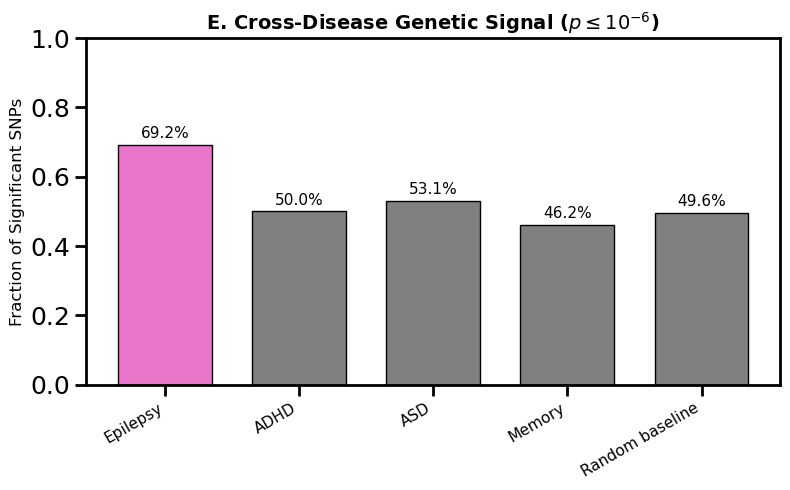

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# 数据准备
categories = ['Epilepsy', 'ADHD', 'ASD', 'Memory', 'Random baseline']
values = [0.692, 0.500, 0.531, 0.462, 0.496]
# 颜色设置 (Epilepsy为粉色，其余为灰色)
colors = ['#ea76cb', '#808080', '#808080', '#808080', '#808080']

# 创建图表
fig, ax = plt.subplots(figsize=(8, 5))

# 绘制柱状图，设置黑色边框
bars = ax.bar(categories, values, color=colors, edgecolor='black', width=0.7)

# 设置Y轴范围
ax.set_ylim(0, 1.0)

# 添加标题和标签
ax.set_title('E. Cross-Disease Genetic Signal ($p \leq 10^{-6}$)', fontsize=14, fontweight='bold')
ax.set_ylabel('Fraction of Significant SNPs', fontsize=12)

# 在柱子上方添加数值标签
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height*100:.1f}%',
            ha='center', va='bottom', fontsize=11)

# 调整X轴标签角度，防止重叠（原图是倾斜的）
plt.xticks(rotation=30, ha='right', fontsize=11)

# 去除顶部和右侧的边框线（使其更像原图风格）
# ax.spines['top'].set_visible(False) # 原图似乎保留了框线，如果需要去框线可取消注释
# ax.spines['right'].set_visible(False)

# 紧凑布局
plt.tight_layout()

# 显示图表
plt.show()

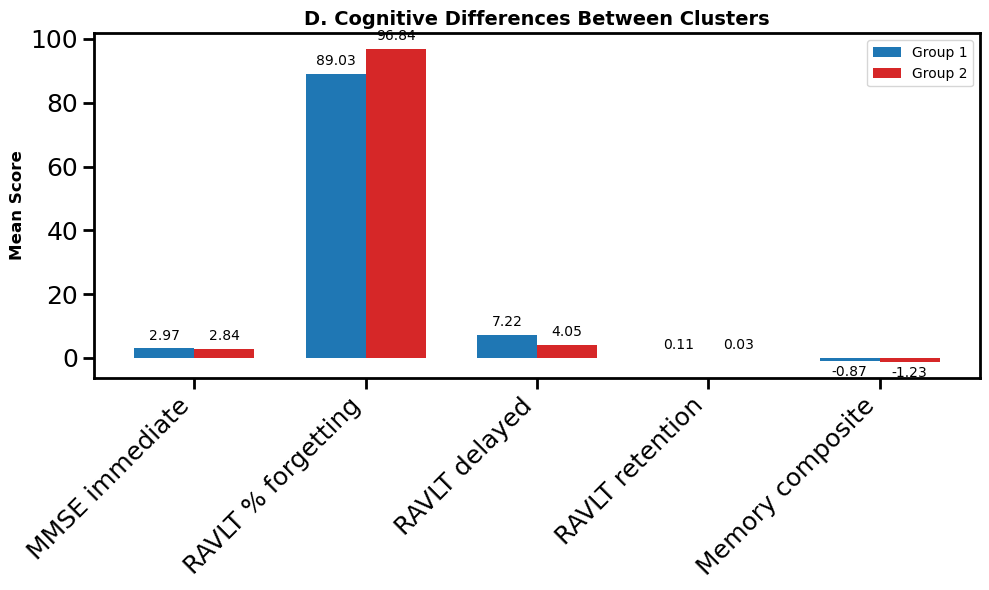

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# 数据设置
labels = ['MMSE immediate', 'RAVLT % forgetting', 'RAVLT delayed', 'RAVLT retention', 'Memory composite']
group1_means = [2.97, 89.03, 7.22, 0.11, -0.87]
group2_means = [2.84, 96.84, 4.05, 0.03, -1.23]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

# 绘制柱状图
rects1 = ax.bar(x - width/2, group1_means, width, label='Group 1', color='#1f77b4')
rects2 = ax.bar(x + width/2, group2_means, width, label='Group 2', color='#d62728')

# 添加文本标签函数
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        # 处理负数情况，标签位置调整
        xy_pos = height + 0.5 if height >= 0 else height - 0.5
        ax.annotate(f'{height}',
                    xy=(rect.get_x() + rect.get_width() / 2, xy_pos),
                    xytext=(0, 3 if height >=0 else -12),  # 垂直偏移
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

autolabel(rects1)
autolabel(rects2)

# 设置标题和轴标签
ax.set_ylabel('Mean Score', fontsize=12, fontweight='bold')
ax.set_title('D. Cognitive Differences Between Clusters', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.legend()

# 添加 "Lower is better" 箭头和文字

# 调整布局以防标签被切掉
plt.tight_layout()
plt.show()

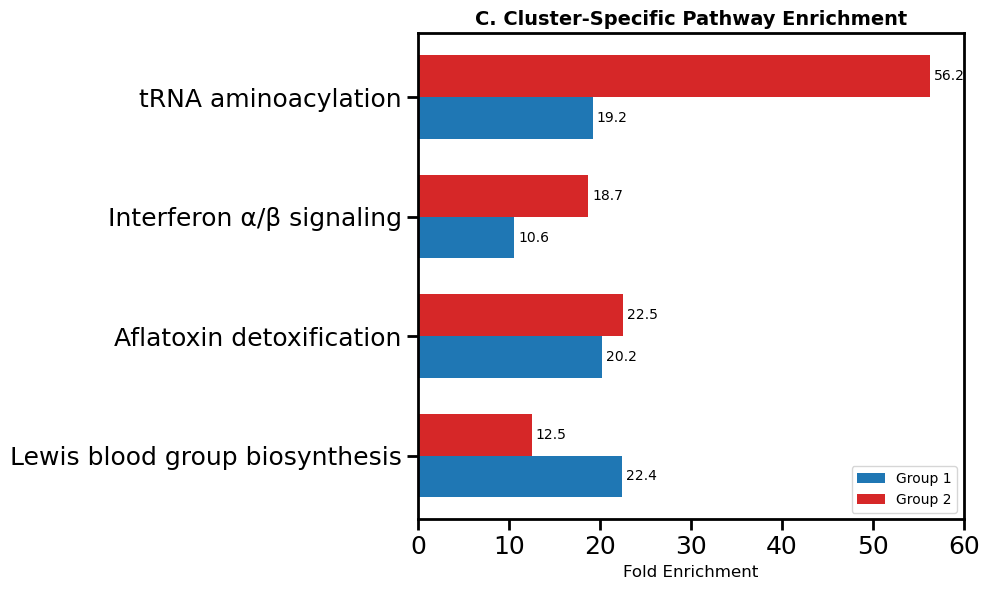

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# 数据
categories = ['Lewis blood group biosynthesis', 'Aflatoxin detoxification', 
              'Interferon α/β signaling', 'tRNA aminoacylation']
# 注意：matplotlib默认从下往上画，所以数据顺序可能需要反过来，或者y轴反转
# 这里按图示从下到上的顺序排列
categories_rev = categories # 保持列表顺序，绘图时控制

group1_vals = [22.4, 20.2, 10.6, 19.2] # 蓝色
group2_vals = [12.5, 22.5, 18.7, 56.2] # 红色

y = np.arange(len(categories))
height = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

# 绘制横向柱状图
# 注意：图例中Group 1在下(蓝色)，Group 2在上(红色)，但在每个类别里，蓝色在下，红色在上
rects1 = ax.barh(y - height/2, group1_vals, height, label='Group 1', color='#1f77b4')
rects2 = ax.barh(y + height/2, group2_vals, height, label='Group 2', color='#d62728')

# 添加数值标签
def autolabel_h(rects):
    for rect in rects:
        width_val = rect.get_width()
        ax.annotate(f'{width_val}',
                    xy=(width_val, rect.get_y() + rect.get_height() / 2),
                    xytext=(3, 0),  # 水平偏移
                    textcoords="offset points",
                    ha='left', va='center', fontsize=10)

autolabel_h(rects1)
autolabel_h(rects2)

# 设置标签和标题
ax.set_xlabel('Fold Enrichment', fontsize=12)
ax.set_title('C. Cluster-Specific Pathway Enrichment', fontsize=14, fontweight='bold')
ax.set_yticks(y)
ax.set_yticklabels(categories)
ax.set_xlim(0, 60) # 根据最大值调整范围

# 图例放在右下角
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

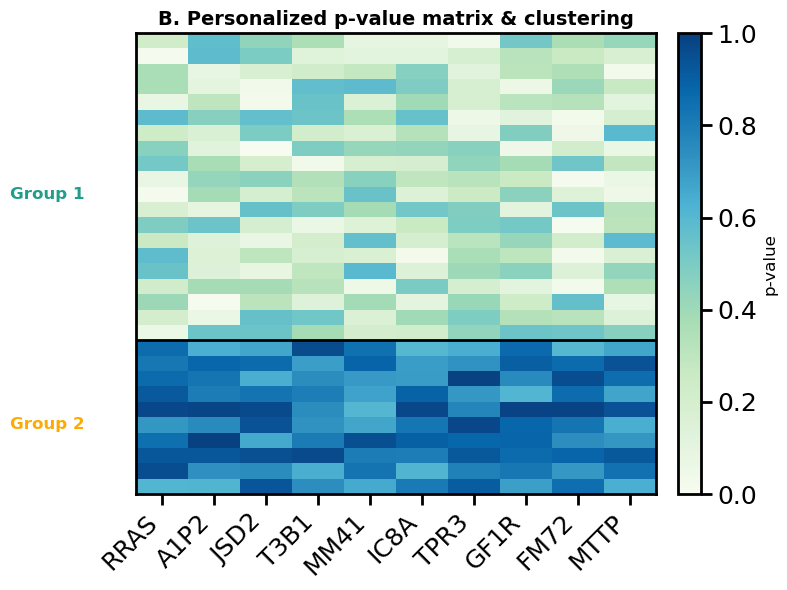

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# 模拟数据生成 (模仿图中的模式)
np.random.seed(42)
# Group 1: 较浅，值较小，随机性大 (约20行)
data_g1 = np.random.uniform(0, 0.6, size=(20, 10)) 
# Group 2: 深蓝色为主，值较大 (约10行)
data_g2 = np.random.uniform(0.6, 1.0, size=(10, 10))
# 合并数据
data = np.vstack([data_g1, data_g2])

# 基因标签
genes = ['RRAS', 'A1P2', 'JSD2', 'T3B1', 'MM41', 'IC8A', 'TPR3', 'GF1R', 'FM72', 'MTTP']

fig, ax = plt.subplots(figsize=(8, 6))

# 绘制热力图，使用 GnBu (Green-Blue) 色谱
# vmin=0, vmax=1 对应图例
im = ax.imshow(data, cmap='GnBu', aspect='auto', vmin=0, vmax=1)

# 设置X轴
ax.set_xticks(np.arange(len(genes)))
ax.set_xticklabels(genes, rotation=45, ha='right')

# 移除Y轴刻度，添加左侧的分组标签
ax.set_yticks([])

# 添加左侧文字标签
# Group 1 (绿色文字)
ax.text(-1.5, 10, 'Group 1', color='#1f9e89', fontsize=12, ha='right', va='center', fontweight='bold')
# Group 2 (橙色文字)
ax.text(-1.5, 25, 'Group 2', color='#ffaa00', fontsize=12, ha='right', va='center', fontweight='bold')

# 添加中间的分隔线 (黑色实线)
ax.axhline(y=19.5, color='black', linewidth=2)

# 添加标题
ax.set_title('B. Personalized p-value matrix & clustering', fontsize=14, fontweight='bold')

# 添加颜色条 (Colorbar)
cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('p-value', fontsize=12)

plt.tight_layout()
plt.show()

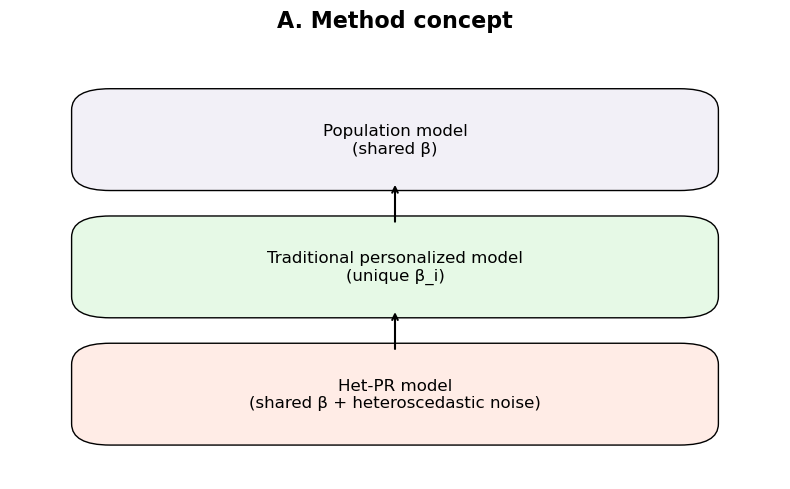

In [27]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(8, 5))

# 定义框的属性
box_width = 0.8
box_height = 0.2
x_center = 0.5

# 定义三个框的中心Y坐标（从下到上）
y_positions = [0.2, 0.5, 0.8]

colors = ['#ffece6', '#e6f9e6', '#f2f0f7']  # 浅红(下), 浅绿(中), 浅紫(上)
texts = [
    "Het-PR model\n(shared β + heteroscedastic noise)",
    "Traditional personalized model\n(unique β_i)",
    "Population model\n(shared β)"
]

# 绘制圆角矩形和文字
for y, color, text in zip(y_positions, colors, texts):
    rect = patches.FancyBboxPatch(
        (x_center - box_width/2, y - box_height/2),
        box_width, box_height,
        boxstyle="round,pad=0.02,rounding_size=0.05",
        ec="black", fc=color,
        mutation_scale=1
    )
    ax.add_patch(rect)
    ax.text(x_center, y, text, ha='center', va='center', fontsize=12)

# 绘制箭头（从下往上）
# 箭头1：框1(下) -> 框2(中)
ax.annotate(
    '', 
    xy=(x_center, y_positions[1] - box_height/2),      # 目标点：中间框底边
    xytext=(x_center, y_positions[0] + box_height/2),  # 起点：底部框顶边
    arrowprops=dict(arrowstyle='->', lw=1.5, color='black')
)

# 箭头2：框2(中) -> 框3(上)
ax.annotate(
    '',
    xy=(x_center, y_positions[2] - box_height/2),      # 目标点：顶部框底边
    xytext=(x_center, y_positions[1] + box_height/2),  # 起点：中间框顶边
    arrowprops=dict(arrowstyle='->', lw=1.5, color='black')
)

# 设置标题
ax.set_title('A. Method concept', fontsize=16, fontweight='bold', pad=20)

# 移除坐标轴
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')

plt.tight_layout()
plt.show()


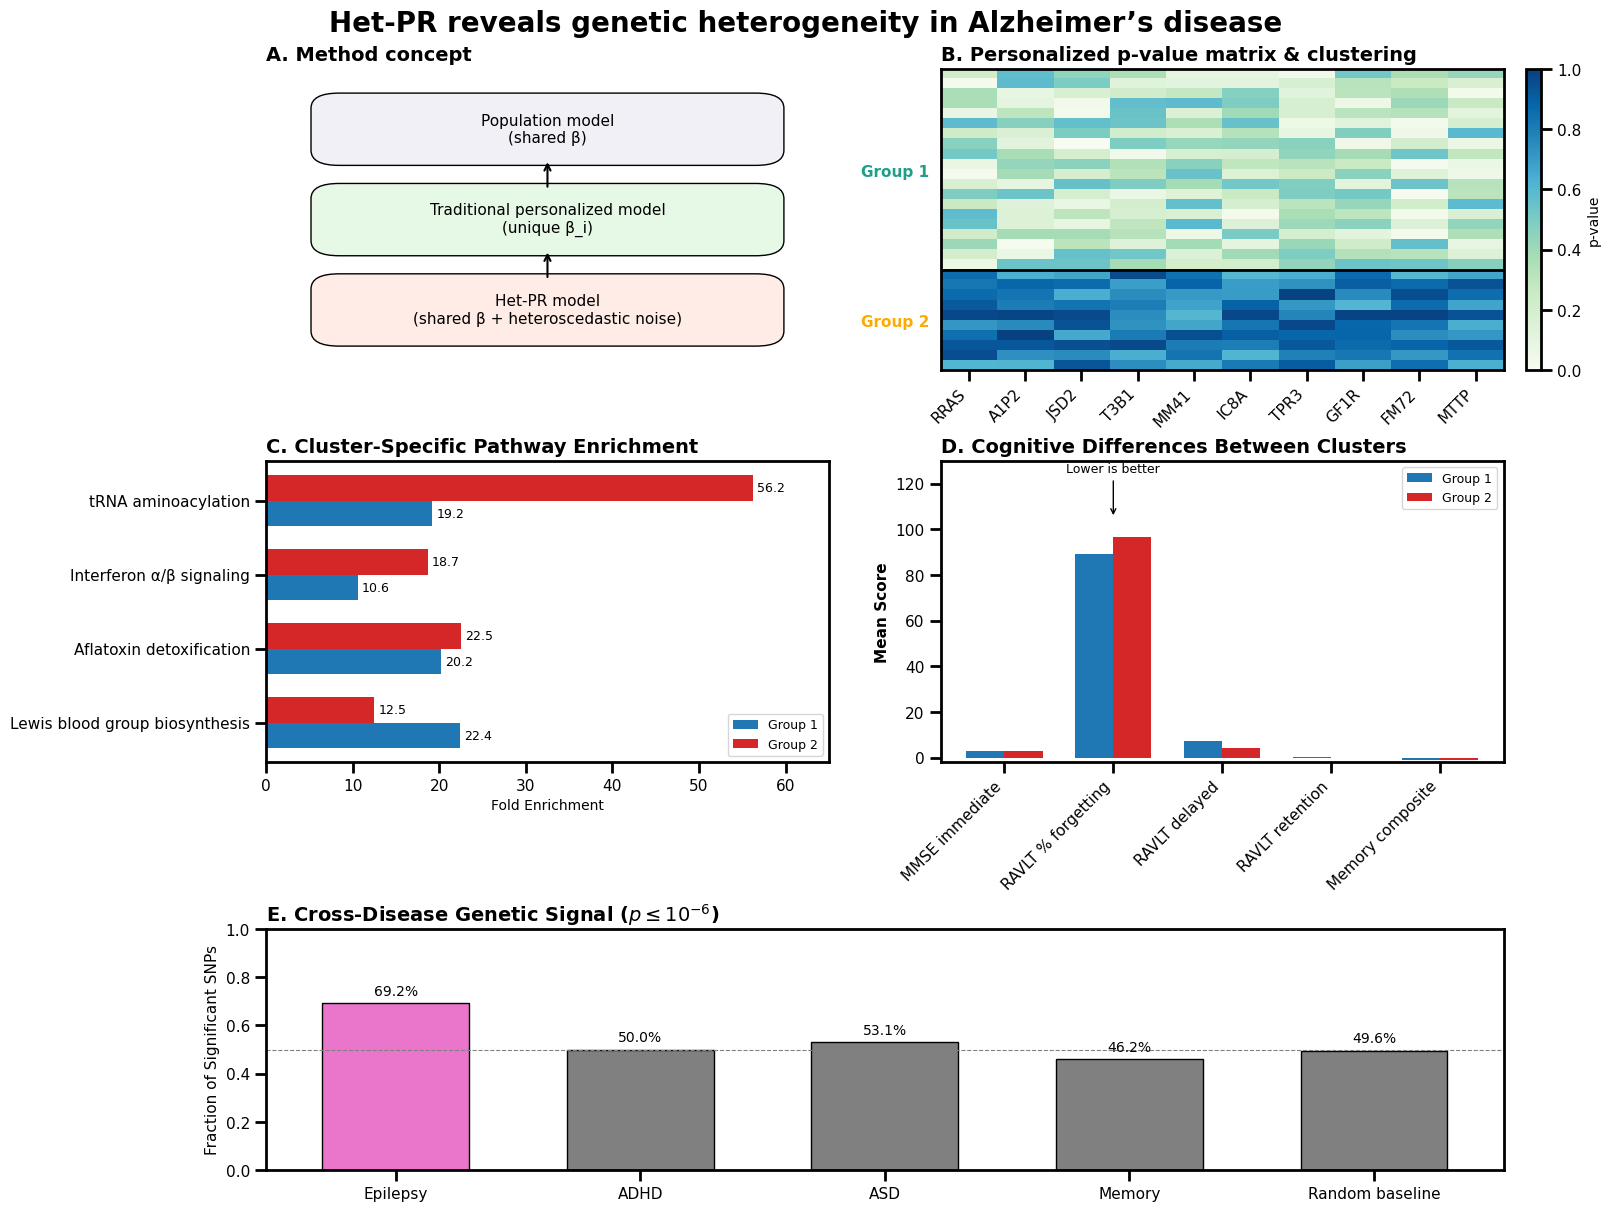

In [34]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# ==========================================
# 1. 定义五个绘图函数 (保持不变)
# ==========================================

def plot_panel_a(ax):
    """绘制 A. Method concept"""
    # 定义框的属性
    box_width = 0.8
    box_height = 0.2
    x_center = 0.5
    y_positions = [0.2, 0.5, 0.8]
    colors = ['#ffece6', '#e6f9e6', '#f2f0f7']
    texts = [
        "Het-PR model\n(shared β + heteroscedastic noise)",
        "Traditional personalized model\n(unique β_i)",
        "Population model\n(shared β)"
    ]

    # 绘制圆角矩形和文字
    for y, color, text in zip(y_positions, colors, texts):
        rect = patches.FancyBboxPatch(
            (x_center - box_width/2, y - box_height/2),
            box_width, box_height,
            boxstyle="round,pad=0.02,rounding_size=0.05",
            ec="black", fc=color,
            mutation_scale=1
        )
        ax.add_patch(rect)
        ax.text(x_center, y, text, ha='center', va='center', fontsize=11)

    # 绘制箭头：下 -> 中
    ax.annotate(
        '',
        xy=(x_center, y_positions[1] - box_height/2),      # 箭头终点：中间框的下边缘
        xytext=(x_center, y_positions[0] + box_height/2),  # 箭头起点：下方框的上边缘
        arrowprops=dict(arrowstyle='->', lw=1.5, color='black')
    )

    # 绘制箭头：中 -> 上
    ax.annotate(
        '',
        xy=(x_center, y_positions[2] - box_height/2),      # 箭头终点：上方框的下边缘
        xytext=(x_center, y_positions[1] + box_height/2),  # 箭头起点：中间框的上边缘
        arrowprops=dict(arrowstyle='->', lw=1.5, color='black')
    )

    ax.set_title('A. Method concept', fontsize=14, fontweight='bold', loc='left')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')


def plot_panel_b(ax):
    """绘制 B. Personalized p-value matrix"""
    np.random.seed(42)
    data_g1 = np.random.uniform(0, 0.6, size=(20, 10))
    data_g2 = np.random.uniform(0.6, 1.0, size=(10, 10))
    data = np.vstack([data_g1, data_g2])
    genes = ['RRAS', 'A1P2', 'JSD2', 'T3B1', 'MM41', 'IC8A', 'TPR3', 'GF1R', 'FM72', 'MTTP']

    im = ax.imshow(data, cmap='GnBu', aspect='auto', vmin=0, vmax=1)

    ax.set_xticks(np.arange(len(genes)))
    ax.set_xticklabels(genes, rotation=45, ha='right')
    ax.set_yticks([])

    # 左侧文字标签
    ax.text(-0.02, 0.66, 'Group 1', color='#1f9e89', fontsize=11,
            ha='right', va='center', fontweight='bold', transform=ax.transAxes)
    ax.text(-0.02, 0.16, 'Group 2', color='#ffaa00', fontsize=11,
            ha='right', va='center', fontweight='bold', transform=ax.transAxes)

    # 分隔线
    ax.axhline(y=19.5, color='black', linewidth=2)

    ax.set_title('B. Personalized p-value matrix & clustering', fontsize=14, fontweight='bold', loc='left')

    # Colorbar
    cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('p-value', fontsize=10)


def plot_panel_c(ax):
    """绘制 C. Cluster-Specific Pathway Enrichment"""
    categories = ['Lewis blood group biosynthesis', 'Aflatoxin detoxification',
                  'Interferon α/β signaling', 'tRNA aminoacylation']
    group1_vals = [22.4, 20.2, 10.6, 19.2]
    group2_vals = [12.5, 22.5, 18.7, 56.2]

    y = np.arange(len(categories))
    height = 0.35

    rects1 = ax.barh(y - height/2, group1_vals, height, label='Group 1', color='#1f77b4')
    rects2 = ax.barh(y + height/2, group2_vals, height, label='Group 2', color='#d62728')

    # 数值标签
    for rect in list(rects1) + list(rects2):
        width_val = rect.get_width()
        ax.annotate(f'{width_val}',
                    xy=(width_val, rect.get_y() + rect.get_height() / 2),
                    xytext=(3, 0), textcoords="offset points",
                    ha='left', va='center', fontsize=9)

    ax.set_xlabel('Fold Enrichment', fontsize=10)
    ax.set_title('C. Cluster-Specific Pathway Enrichment', fontsize=14, fontweight='bold', loc='left')
    ax.set_yticks(y)
    ax.set_yticklabels(categories)
    ax.set_xlim(0, 65)
    ax.legend(loc='lower right', fontsize=9)


def plot_panel_d(ax):
    """绘制 D. Cognitive Differences"""
    labels = ['MMSE immediate', 'RAVLT % forgetting', 'RAVLT delayed', 'RAVLT retention', 'Memory composite']
    group1_means = [2.97, 89.03, 7.22, 0.11, -0.87]
    group2_means = [2.84, 96.84, 4.05, 0.03, -1.23]

    x = np.arange(len(labels))
    width = 0.35

    ax.bar(x - width/2, group1_means, width, label='Group 1', color='#1f77b4')
    ax.bar(x + width/2, group2_means, width, label='Group 2', color='#d62728')

    # 绘制 "Lower is better" 箭头
    ax.annotate('Lower is better', xy=(1, 105), xytext=(1, 125),
                arrowprops=dict(facecolor='black', arrowstyle='->'),
                ha='center', fontsize=9)

    ax.set_ylabel('Mean Score', fontsize=11, fontweight='bold')
    ax.set_title('D. Cognitive Differences Between Clusters', fontsize=14, fontweight='bold', loc='left')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.legend(fontsize=9)
    ax.set_ylim(-2, 130)


def plot_panel_e(ax):
    """绘制 E. Cross-Disease Genetic Signal"""
    categories = ['Epilepsy', 'ADHD', 'ASD', 'Memory', 'Random baseline']
    values = [0.692, 0.500, 0.531, 0.462, 0.496]
    colors = ['#ea76cb', '#808080', '#808080', '#808080', '#808080']

    bars = ax.bar(categories, values, color=colors, edgecolor='black', width=0.6)
    ax.set_ylim(0, 1.0)
    ax.set_title('E. Cross-Disease Genetic Signal ($p \\leq 10^{-6}$)', fontsize=14, fontweight='bold', loc='left')
    ax.set_ylabel('Fraction of Significant SNPs', fontsize=11)

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height*100:.1f}%', ha='center', va='bottom', fontsize=10)

    ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=0.8)


# ==========================================
# 2. 组合大图 (Main Layout)
# ==========================================

fig = plt.figure(figsize=(16, 12), constrained_layout=True)

# ------------------------------------------------------------------
# 修改部分：添加总标题
# fontsize 设置字体大小，fontweight='bold' 设置加粗
# ------------------------------------------------------------------
fig.suptitle("Het‑PR reveals genetic heterogeneity in Alzheimer’s disease", 
             fontsize=20, fontweight='bold')

gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 0.8])

ax_a = fig.add_subplot(gs[0, 0])
ax_b = fig.add_subplot(gs[0, 1])
ax_c = fig.add_subplot(gs[1, 0])
ax_d = fig.add_subplot(gs[1, 1])
ax_e = fig.add_subplot(gs[2, :])

plot_panel_a(ax_a)
plot_panel_b(ax_b)
plot_panel_c(ax_c)
plot_panel_d(ax_d)
plot_panel_e(ax_e)

plt.show()